# Load Libraries

In [ ]:
# install.packages("changepoint")
install.packages("forecast")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘xts’, ‘TTR’, ‘quadprog’, ‘quantmod’, ‘colorspace’, ‘fracdiff’, ‘lmtest’, ‘timeDate’, ‘tseries’, ‘urca’, ‘zoo’, ‘RcppArmadillo’




In [ ]:
library(tidyverse)
library(dplyr)
library(forecast)
library(ggplot2)
library(tseries)
library(lmtest)
library(knitr)
library(future)
library(furrr)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




# Setup

In [ ]:
dir.create( "/content/sta477" )

In [ ]:
file_url <- "https://raw.githubusercontent.com/elivatsaas/sta477-final-project/refs/heads/main/Raw_Monthly_Ridership_1_2002_to_2_2025.csv"
options( download.file.method="curl", download.file.extra="-k -L" )
download.file( file_url, "/content/sta477/Raw_Monthly_Ridership_1_2002_to_1_2025.csv" )

In [ ]:
dir( "/content/sta477" )

[1] "Raw_Monthly_Ridership_1_2002_to_1_2025.csv"

In [ ]:
transit <- read.csv("/content/sta477/Raw_Monthly_Ridership_1_2002_to_1_2025.csv")[-1] %>%
  filter(!is.na(NTD.ID))
head(transit)

,NTD.ID,Legacy.NTD.ID,Agency,Mode.Type.of.Service.Status,Reporter.Type,UACE.CD,UZA.Name,Mode,TOS,X3.Mode,⋯,X5.2024,X6.2024,X7.2024,X8.2024,X9.2024,X10.2024,X11.2024,X12.2024,X1.2025,X2.2025
,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,1,0001,King County,Active,Full Reporter,80389,"Seattle--Tacoma, WA",DR,PT,Bus,⋯,90826,82332,86007,90416,86251,94960,80691,87395,96298,83450
2,1,0001,King County,Active,Full Reporter,80389,"Seattle--Tacoma, WA",DR,TX,Bus,⋯,9951,8324,8535,9690,10668,11728,8482,7868,6315,6764
3,1,0001,King County,Active,Full Reporter,80389,"Seattle--Tacoma, WA",FB,DO,Ferry,⋯,38338,46948,67951,62910,46702,37503,25759,24240,26935,22362
4,1,0001,King County,Inactive,Full Reporter,80389,"Seattle--Tacoma, WA",LR,DO,Rail,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
5,1,0001,King County,Active,Full Reporter,80389,"Seattle--Tacoma, WA",MB,DO,Bus,⋯,6401486,5933767,6137519,6019974,6139353,6820828,5983373,5655460,6158381,5748640
6,1,0001,King County,Active,Full Reporter,80389,"Seattle--Tacoma, WA",MB,PT,Bus,⋯,71901,73530,78690,77526,75167,80011,67582,66117,73347,64445


# Cleaning

In [ ]:
transit.tidy <- transit %>%
  pivot_longer(
    cols = 11:288,
    names_to = "months",
    values_to = "UPT")

transit.tidy <- transit.tidy %>%
  mutate(
    log_UPT = log(UPT)
  )
transit.tidy <- transit.tidy %>%
  mutate(
    # Remove the X from the month
    clean_month = gsub("^[^0-9]*([0-9]+)[^0-9]+([0-9]+)$", "\\1.\\2", months),
    month = as.numeric(sub("\\..*", "", clean_month)),
    year = as.numeric(sub(".*\\.", "", clean_month)),
    date = as.Date(paste(year, month, "01", sep = "-"))
  )
head(transit.tidy)

NTD.ID,Legacy.NTD.ID,Agency,Mode.Type.of.Service.Status,Reporter.Type,UACE.CD,UZA.Name,Mode,TOS,X3.Mode,months,UPT,log_UPT,clean_month,month,year,date
<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<date>
1,0001,King County,Active,Full Reporter,80389,"Seattle--Tacoma, WA",DR,PT,Bus,X1.2002,135144,11.81410,1.2002,1,2002,2002-01-01
1,0001,King County,Active,Full Reporter,80389,"Seattle--Tacoma, WA",DR,PT,Bus,X2.2002,127378,11.75491,2.2002,2,2002,2002-02-01
1,0001,King County,Active,Full Reporter,80389,"Seattle--Tacoma, WA",DR,PT,Bus,X3.2002,136030,11.82063,3.2002,3,2002,2002-03-01
1,0001,King County,Active,Full Reporter,80389,"Seattle--Tacoma, WA",DR,PT,Bus,X4.2002,142204,11.86502,4.2002,4,2002,2002-04-01
1,0001,King County,Active,Full Reporter,80389,"Seattle--Tacoma, WA",DR,PT,Bus,X5.2002,144697,11.88240,5.2002,5,2002,2002-05-01
1,0001,King County,Active,Full Reporter,80389,"Seattle--Tacoma, WA",DR,PT,Bus,X6.2002,131833,11.78929,6.2002,6,2002,2002-06-01


In [ ]:
# Get all jurisdiction for each id
jurisdiction.modes <- transit.tidy %>%
  group_by(NTD.ID) %>%
  summarize(
    modes.list = paste(sort(unique(Mode)), collapse = ", "),
    mode.count = n_distinct(Mode),
    .groups = "drop"
  )

# Aggregate all jurisdiction data
transit.tidy.aggregated <- transit.tidy %>%
   group_by(NTD.ID, months, year, month, date)  %>%
  summarize(
    UPT.sum = sum(UPT, na.rm = TRUE),
    #Above line will return 0 if all UPT is NA, this fixes that
    UPT.sum = if_else(all(is.na(UPT)), NA_real_, UPT.sum),
    log.UPT.sum = if_else(is.na(UPT.sum), NA_real_, log(UPT.sum)),
    .groups = "drop"
  ) %>%
  left_join(jurisdiction.modes, by = "NTD.ID") %>%
  arrange(date)

#Calculate months in data
TOTAL.MONTHS <-  (2025-2002)*12+2

aggregated.missing.data <- transit.tidy.aggregated %>%
  group_by(NTD.ID, modes.list, mode.count) %>%
  summarize(
    missing.count = sum(is.na(UPT.sum) | UPT.sum == 0, na.rm = TRUE),
    missing.percentage = ifelse(missing.count == 0, 0, missing.count / TOTAL.MONTHS),
    .groups = "drop"
  )

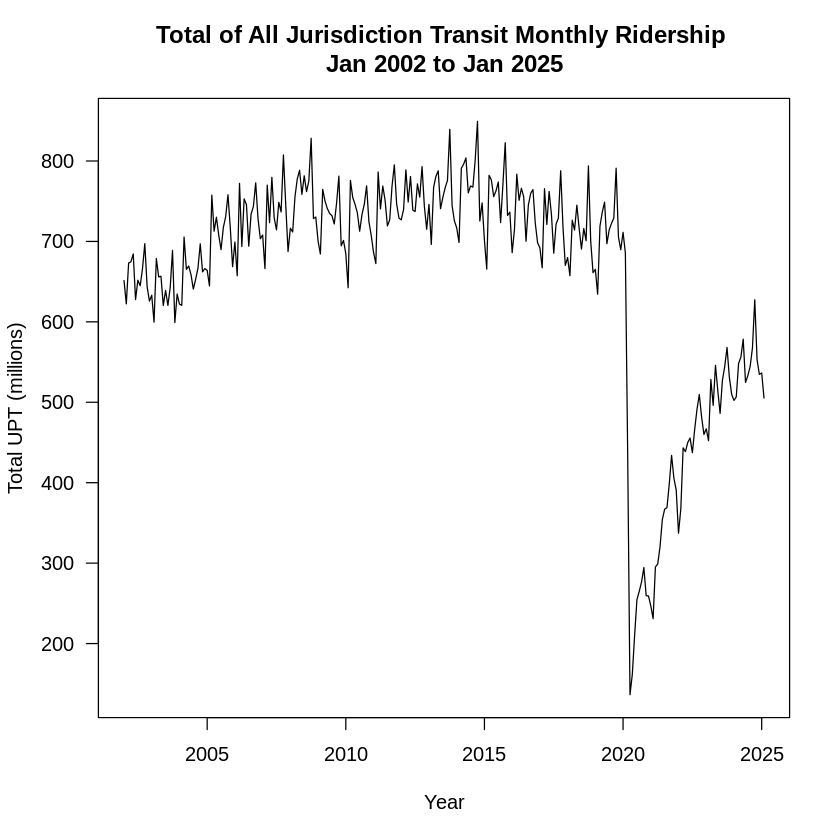

In [ ]:
# Get only complete jurisdictions
complete.jurisdictions <- aggregated.missing.data %>%
  filter(missing.count == 0) %>%
  select(NTD.ID)


transit.complete <- transit.tidy.aggregated %>%
  filter(NTD.ID %in% complete.jurisdictions$NTD.ID)

# Combine all complete data into national level data
transit.all <- transit.complete %>%
  group_by(date) %>%
  summarize(total.UPT = sum(UPT.sum,na.rm = TRUE))%>%
  ungroup()%>%
  mutate(total.log.UPT = log(total.UPT))

# Total UPT plot
transit.t <- ts( transit.all$total.UPT,  start=c(2002,1), freq=12 )
plot.ts(transit.t,
        main="Total of All Jurisdiction Transit Monthly Ridership \nJan 2002 to Jan 2025",
        xlab = "Year",
        ylab = "Total UPT (millions)",
        yaxt = "n") # Suppress y-axis

# Add custom y-axis
axis(2, at = axTicks(2),
     labels = format(axTicks(2)/1000000, big.mark = ","),
     las = 1)

# log upt time series
transit.l.t <- ts( transit.all$total.log.UPT, start=c(2002,1), freq=12 )

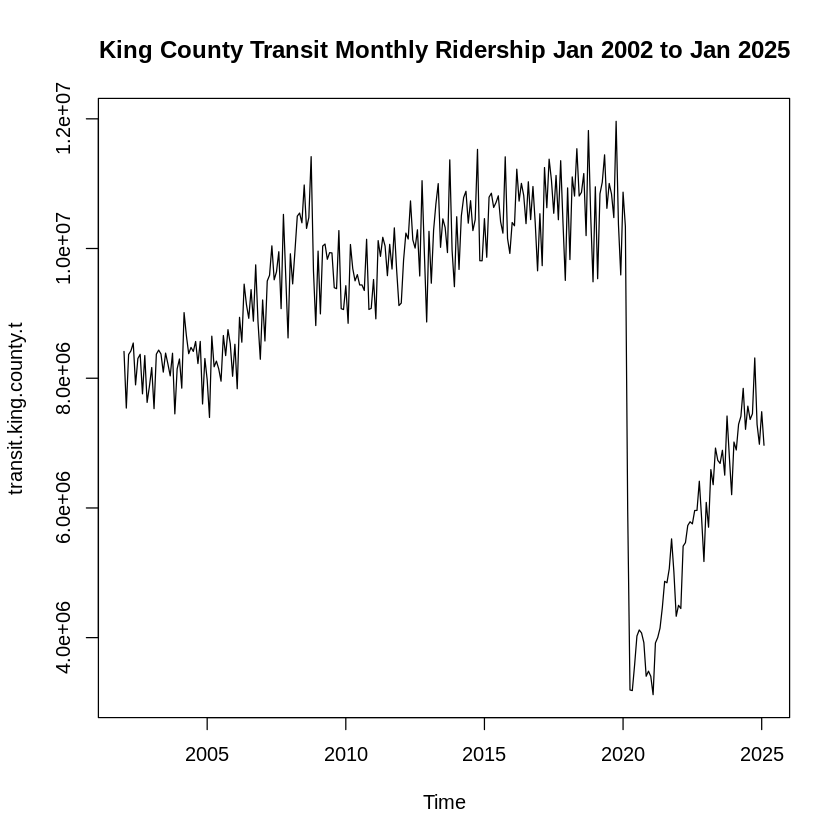

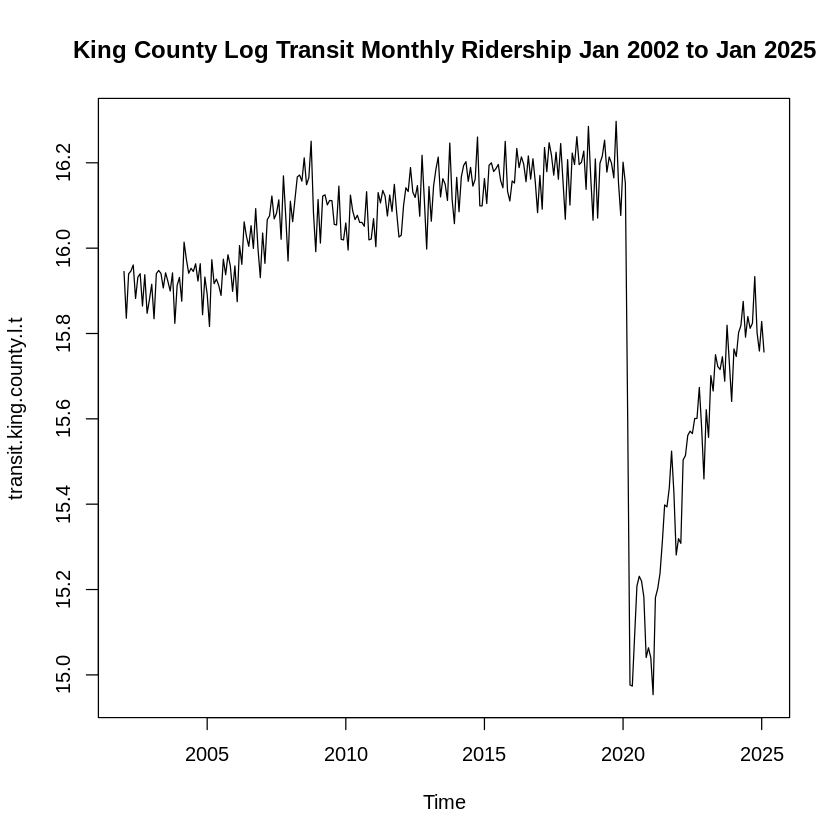

In [ ]:
transit.king.county <- transit.tidy.aggregated %>% filter( NTD.ID == 001) %>%
  arrange(date)

transit.king.county.t <- ts( transit.king.county$UPT.sum, start=c(2002,1), freq=12 )
#transit.king.county.t <- diff(diff(transit.king.county.t, lag=12))
plot.ts(transit.king.county.t, main="King County Transit Monthly Ridership Jan 2002 to Jan 2025" )


transit.king.county.l.t <- ts( transit.king.county$log.UPT.sum, start=c(2002,1), freq=12 )
#transit.king.county.l.t <- diff(diff(transit.king.county.l.t, lag=12))

plot.ts(transit.king.county.l.t, main="King County Log Transit Monthly Ridership Jan 2002 to Jan 2025" )

# Summation Analysis

In [ ]:
# preparing time series for analysis
transit.pre <- window(transit.t, end = c(2020, 1))

transit.l.pre <- window(transit.l.t, end = c(2020, 1))
transit.l.diff <- diff(transit.l.pre, lag = 12)

In [ ]:
# Verify time series is not stationary already
adf.test(transit.pre)


	Augmented Dickey-Fuller Test

data:  transit.pre
Dickey-Fuller = -2.0686, Lag order = 5, p-value = 0.5472
alternative hypothesis: stationary


## Analysis of applying log function

Comparing transit data and log transformed data

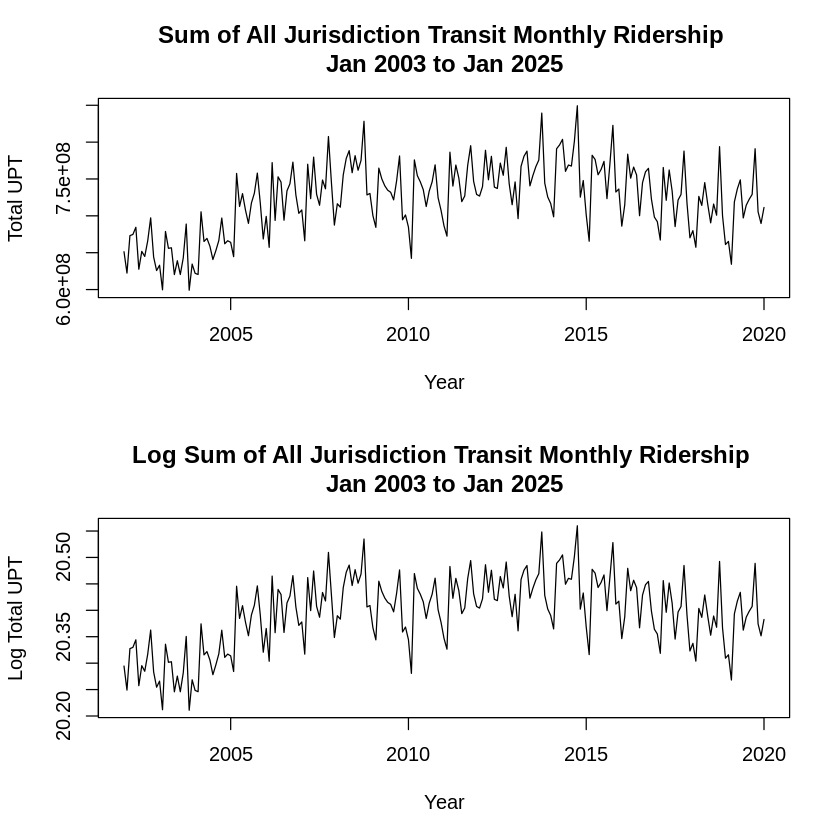

In [ ]:
par(mfrow = c(2,1))
plot.ts(transit.pre,
        main="Sum of All Jurisdiction Transit Monthly Ridership \nJan 2003 to Jan 2025",
        xlab = "Year",
        ylab = "Total UPT" )
plot.ts(transit.l.pre,
        main="Log Sum of All Jurisdiction Transit Monthly Ridership \nJan 2003 to Jan 2025",
        xlab = "Year",
        ylab = "Log Total UPT" )

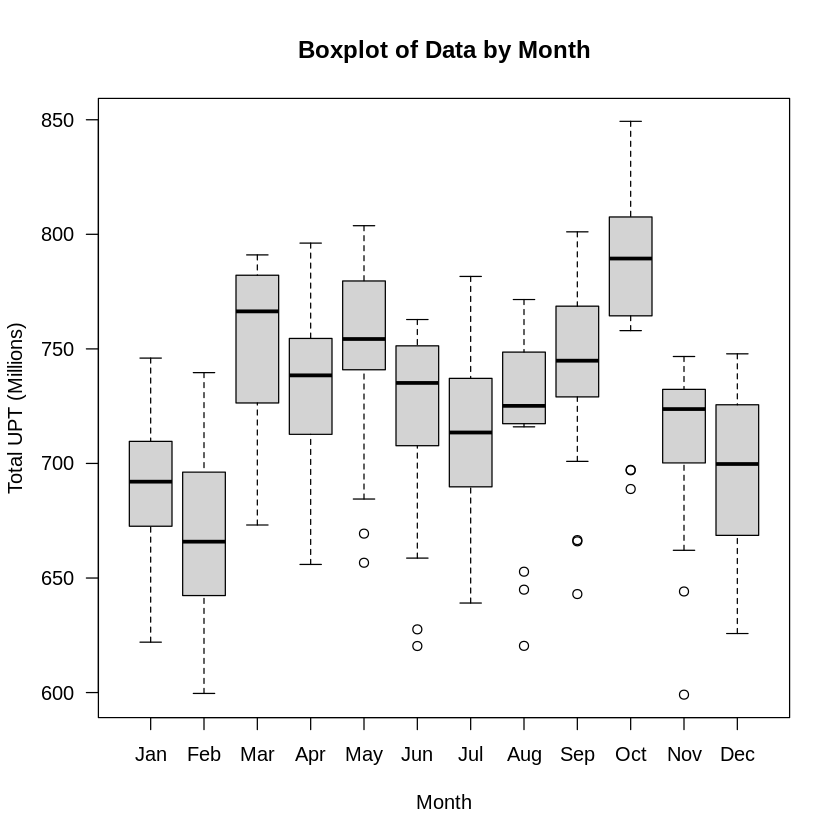

In [ ]:
# Examine if log transformation stabilized the variance
# par(mfrow = c(2, 1))
boxplot(split(as.vector(transit.pre), cycle(transit.pre)),
        main = "Boxplot of Data by Month",
        xlab = "Month", ylab = "Total UPT (Millions)",
         names = month.abb,
                yaxt = "n") # Suppress y-axis

# Add custom y-axis
axis(2, at = axTicks(2),
     labels = format(axTicks(2)/1000000, big.mark = ","),
     las = 1)
#boxplot(split(as.vector(transit.l.t), cycle(transit.l.t)),
 #       main = "Boxplot of Log-Transformed Data by Month",
  #      xlab = "Month", ylab = "Log(Total UPT)")

## ACF and PACF Analysis

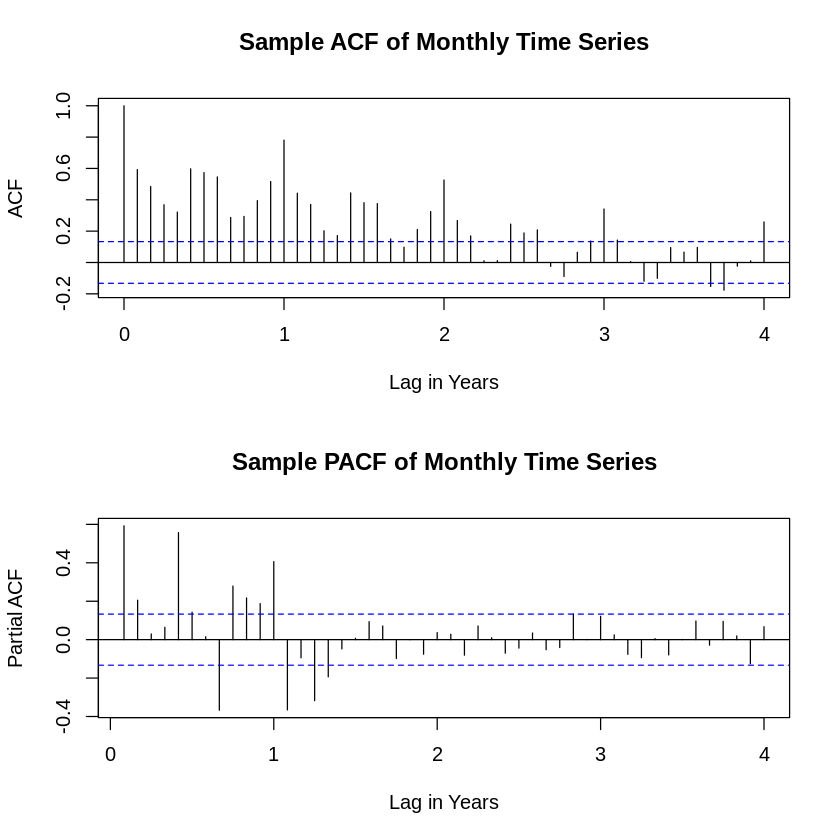

In [ ]:
par(mfrow = c(2,1))
acf( transit.pre, main = "Sample ACF of Monthly Time Series", xlab = "Lag in Years", lag.max = 48)
pacf( transit.pre, main = "Sample PACF of Monthly Time Series", xlab = "Lag in Years", lag.max = 48)

## Differencing

### Lag-12 Differencing

Warning message in adf.test(transit.diff.alt):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  transit.diff.alt
Dickey-Fuller = -6.4351, Lag order = 5, p-value = 0.01
alternative hypothesis: stationary


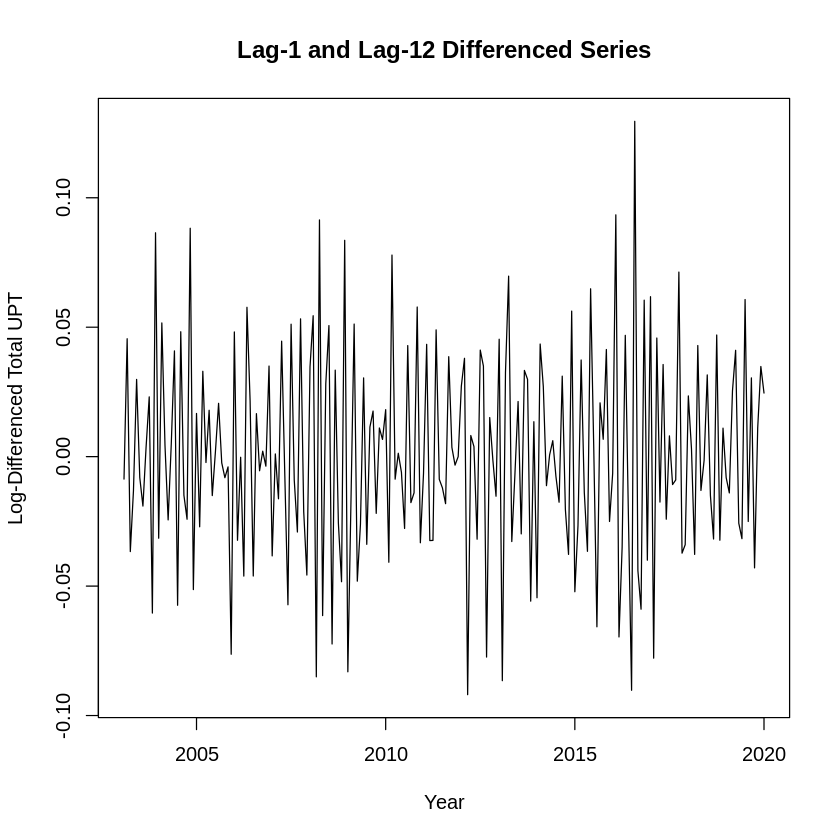

In [ ]:
# Apply seasonal differencing
transit.diff.alt <- diff(diff(transit.l.pre, lag = 12))

# Test for stationarity after seasonal difference
adf.test(transit.diff.alt)

# Visual Inspection for stationarity
par(mfrow = c(1, 1))
plot(transit.diff.alt, main = "Lag-1 and Lag-12 Differenced Series", ylab = "Log-Differenced Total UPT", xlab = "Year")

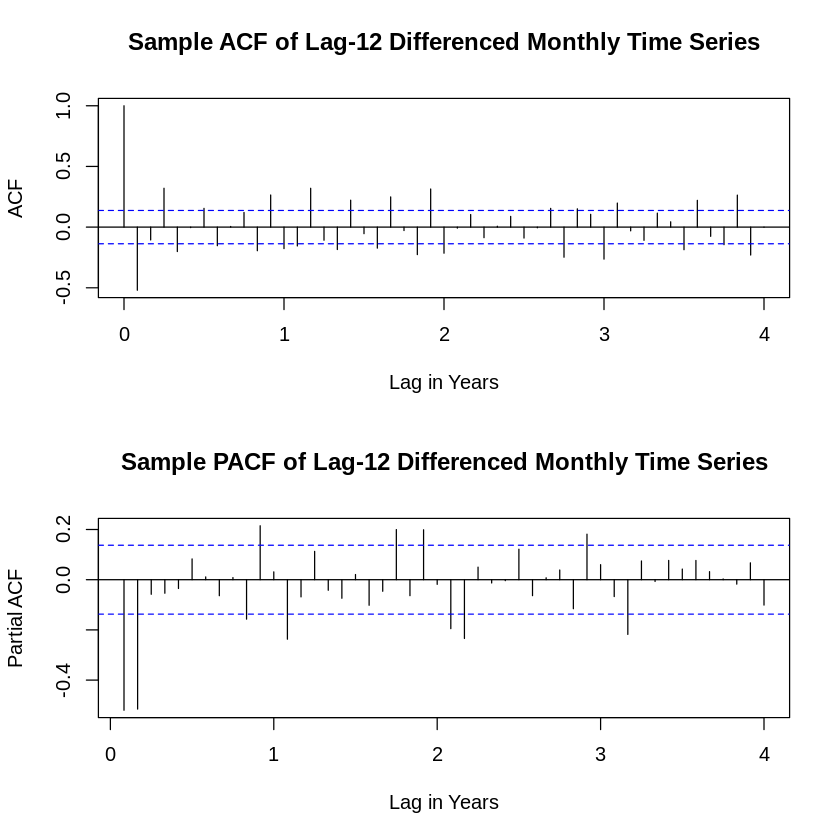

In [ ]:
par(mfrow = c(2,1))
acf( transit.diff.alt, main = "Sample ACF of Lag-12 Differenced Monthly Time Series", xlab = "Lag in Years", lag.max = 48)
pacf( transit.diff.alt, main = "Sample PACF of Lag-12 Differenced Monthly Time Series", xlab = "Lag in Years", lag.max = 48)

The data doesn't really appear to have a trend component so no other differencing will be used to begin with.

Warning message in adf.test(transit.diff.full):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  transit.diff.full
Dickey-Fuller = -6.7081, Lag order = 6, p-value = 0.01
alternative hypothesis: stationary


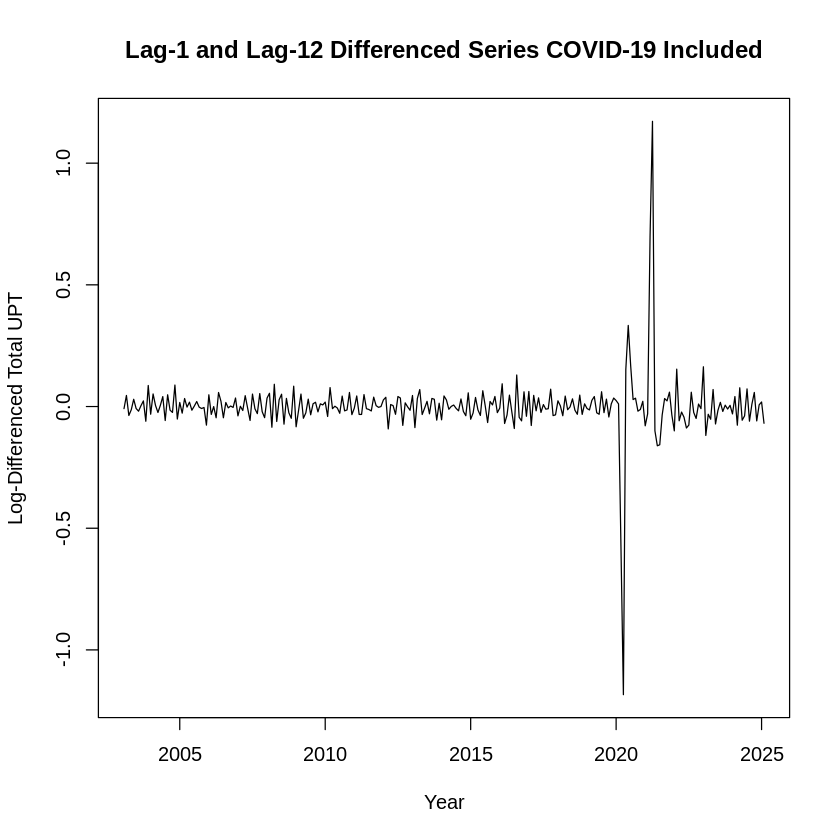

In [ ]:
# Apply seasonal differencing
transit.diff.full <- diff(diff(transit.l.t, lag = 12))

# Test for stationarity after seasonal difference
adf.test(transit.diff.full)

# Visual Inspection for stationarity
par(mfrow = c(1, 1))
plot(transit.diff.full, main = "Lag-1 and Lag-12 Differenced Series COVID-19 Included",ylab = "Log-Differenced Total UPT", xlab = "Year")

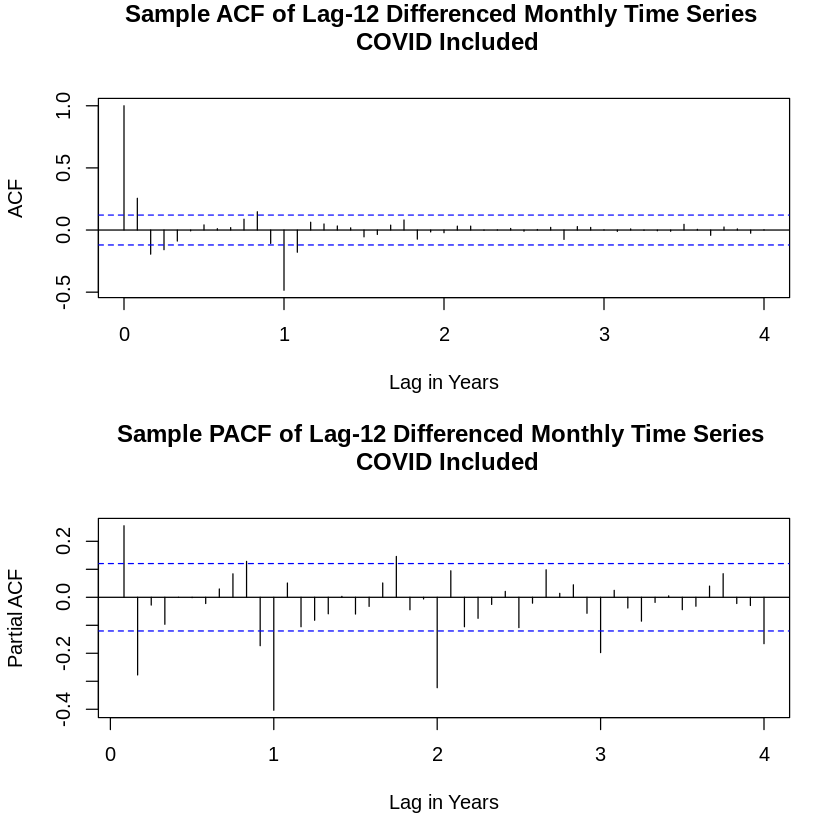

In [ ]:
par(mfrow = c(2,1))
acf( transit.diff.full, main = "Sample ACF of Lag-12 Differenced Monthly Time Series \n COVID Included",xlab = "Lag in Years", lag.max = 48)
pacf( transit.diff.full, main = "Sample PACF of Lag-12 Differenced Monthly Time Series \n COVID Included",xlab = "Lag in Years", lag.max = 48)

# Model Building

## Pre-Covid Model

In [ ]:
# Model fitting - try different SARIMA models
# Model 1: SARIMA(1,1,1)(1,1,1)12
model1 <- Arima(transit.l.pre, order = c(1,1,1), seasonal = c(1,1,1))
# Model 2: SARIMA(0,1,1)(0,1,1)12
model2 <- Arima(transit.l.pre, order = c(0,1,1), seasonal = c(0,1,1))
# Model 3: SARIMA(1,1,0)(1,1,0)12
model3 <- Arima(transit.l.pre, order = c(1,1,0), seasonal = c(1,1,0))
# Model 4: SARIMA(0,1,1)(1,1,0)12
model4 <- Arima(transit.l.pre, order = c(0,1,1), seasonal = c(1,1,0))
# Model 5: SARIMA(1,1,0)(0,1,1)12
model5 <- Arima(transit.l.pre, order = c(1,1,0), seasonal = c(0,1,1))
# Model 6: SARIMA(2,1,0)(1,1,0)12
model6 <- Arima(transit.l.pre, order = c(2,1,0), seasonal = c(1,1,1))
# Model 7: SARIMA(1,1,0)(1,1,0)12
model7 <- Arima(transit.l.pre, order = c(1,1,0), seasonal = c(1,1,1))
# Model 8: SARIMA(2,1,1)(1,1,0)12
model8 <- Arima(transit.l.pre, order = c(2,1,1), seasonal = c(1,1,1))

# Model 9: auto-arima
# model9 <- auto.arima(transit.l.pre, stepwise = FALSE)

In [ ]:
models <- list(model1, model2, model3, model4, model5, model6, model7, model8)
aicc_values <- sapply(models, AIC, k = 2 + 2*(2+2)/(length(transit.l.pre)-2-2-1))
bic_values <- sapply(models, BIC)

model_comparison <- data.frame(
  Model = c("SARIMA(1,1,1)(1,1,1)12", "SARIMA(0,1,1)(0,1,1)12",
            "SARIMA(1,1,0)(1,1,0)12", "SARIMA(0,1,1)(1,1,0)12",
            "SARIMA(1,1,0)(0,1,1)12", "SARIMA(2,1,0)(1,1,0)12",
            "SARIMA(1,1,0)(1,1,0)12", "SARIMA(2,1,1)(1,1,0)12"),
  AICc = aicc_values,
  BIC = bic_values
)
print(model_comparison)

                   Model      AICc       BIC
1 SARIMA(1,1,1)(1,1,1)12 -897.8024 -881.4005
2 SARIMA(0,1,1)(0,1,1)12 -882.1514 -872.3102
3 SARIMA(1,1,0)(1,1,0)12 -799.8075 -789.9663
4 SARIMA(0,1,1)(1,1,0)12 -839.3480 -829.5068
5 SARIMA(1,1,0)(0,1,1)12 -850.8097 -840.9685
6 SARIMA(2,1,0)(1,1,0)12 -917.3019 -900.8999
7 SARIMA(1,1,0)(1,1,0)12 -858.2218 -845.1002
8 SARIMA(2,1,1)(1,1,0)12 -915.3159 -895.6336


In [ ]:
# Choose the best model based on AICc
best_model_index <- which.min(aicc_values)
best_model <- models[[best_model_index]]
print(best_model)

Series: transit.l.pre 
ARIMA(2,1,0)(1,1,1)[12] 

Coefficients:
          ar1      ar2    sar1     sma1
      -0.8099  -0.5156  0.2401  -0.9539
s.e.   0.0619   0.0621  0.0896   0.1419

sigma^2 = 0.0005954:  log likelihood = 463.75
AIC=-917.49   AICc=-917.19   BIC=-900.9


### Model Diagnostics on the best model

In [ ]:
# Parameter significance for the best model
if (requireNamespace("lmtest", quietly = TRUE)) {
  coeftest <- lmtest::coeftest(best_model)
  print(coeftest)

  # Calculate 95% confidence intervals manually
  coef_names <- rownames(coeftest)
  estimates <- coeftest[, 1]
  std_errors <- coeftest[, 2]

  conf_intervals <- data.frame(
    Parameter = coef_names,
    Estimate = estimates,
    StdError = std_errors,
    Lower_95 = estimates - 1.96 * std_errors,
    Upper_95 = estimates + 1.96 * std_errors
  )

  print(conf_intervals)
} else {
  # If lmtest is not available, use confint
  print(summary(best_model))
  cat("\n95% Confidence Intervals:\n")
  print(confint(best_model))
}


z test of coefficients:

      Estimate Std. Error  z value  Pr(>|z|)    
ar1  -0.809873   0.061881 -13.0877 < 2.2e-16 ***
ar2  -0.515649   0.062089  -8.3050 < 2.2e-16 ***
sar1  0.240127   0.089644   2.6787  0.007391 ** 
sma1 -0.953888   0.141919  -6.7213 1.801e-11 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

     Parameter   Estimate   StdError    Lower_95   Upper_95
ar1        ar1 -0.8098726 0.06188063 -0.93115868 -0.6885866
ar2        ar2 -0.5156493 0.06208927 -0.63734425 -0.3939543
sar1      sar1  0.2401267 0.08964398  0.06442453  0.4158289
sma1      sma1 -0.9538880 0.14191947 -1.23205016 -0.6757259



	Ljung-Box test

data:  Residuals from ARIMA(2,1,0)(1,1,1)[12]
Q* = 37.739, df = 20, p-value = 0.009529

Model df: 4.   Total lags used: 24




	Box-Ljung test

data:  residuals(best_model)
X-squared = 37.739, df = 24, p-value = 0.03687


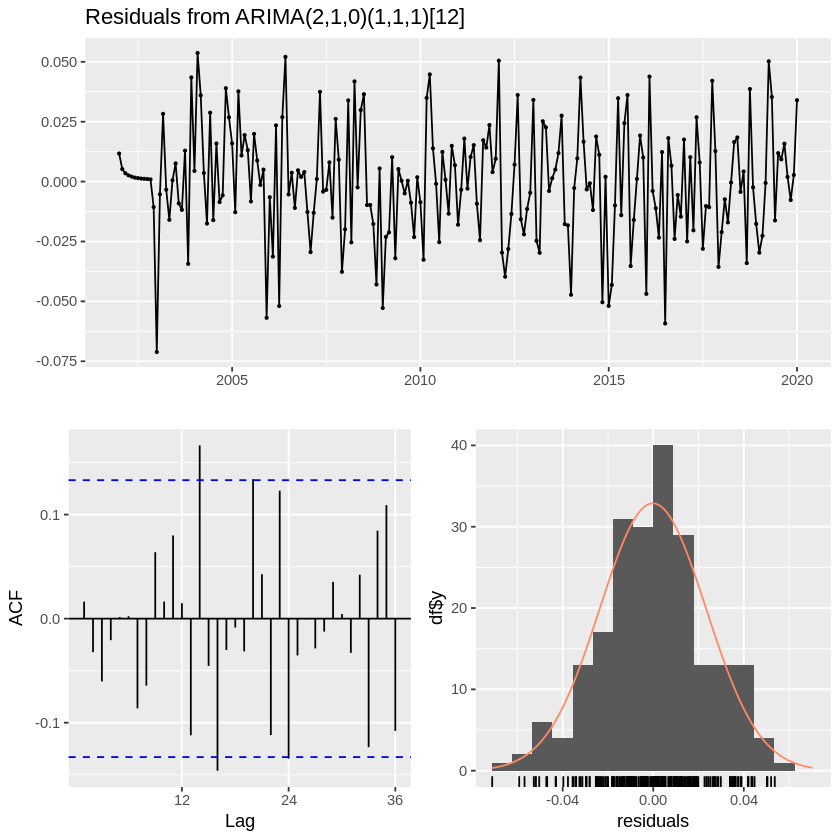

In [ ]:
# Residual analysis for the best model
par(mfrow = c(2, 2))
checkresiduals(best_model)

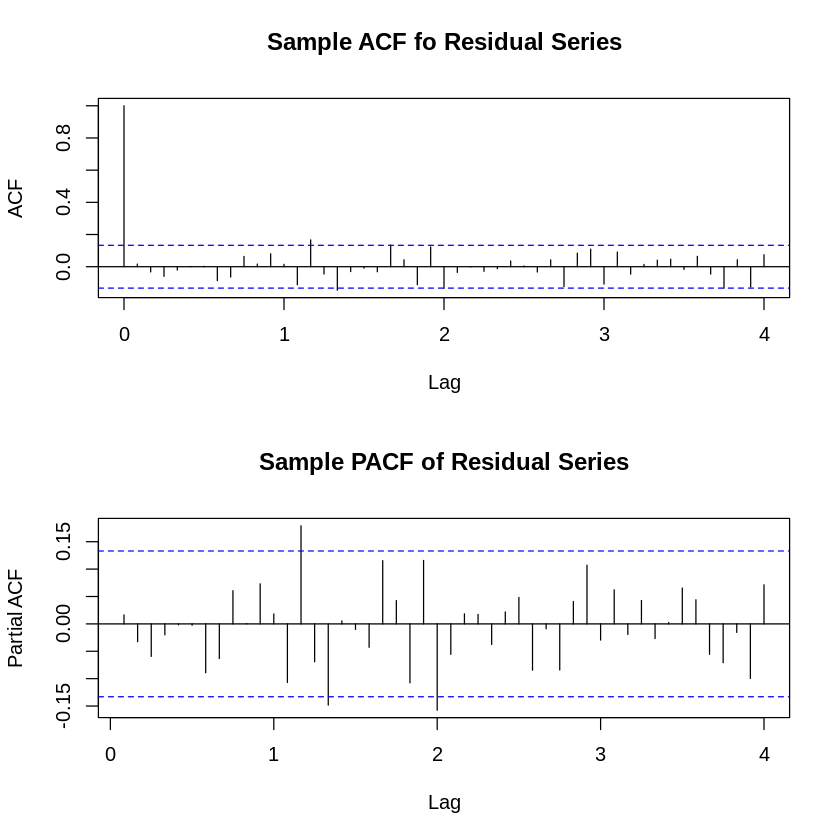

In [ ]:
par(mfrow = c(2,1))
acf( residuals(best_model), main = "Sample ACF fo Residual Series", lag.max = 48)
pacf( residuals(best_model), main = "Sample PACF of Residual Series", lag.max = 48)

### Forecasting

In [ ]:
forecasts <- forecast(best_model, h = 61)

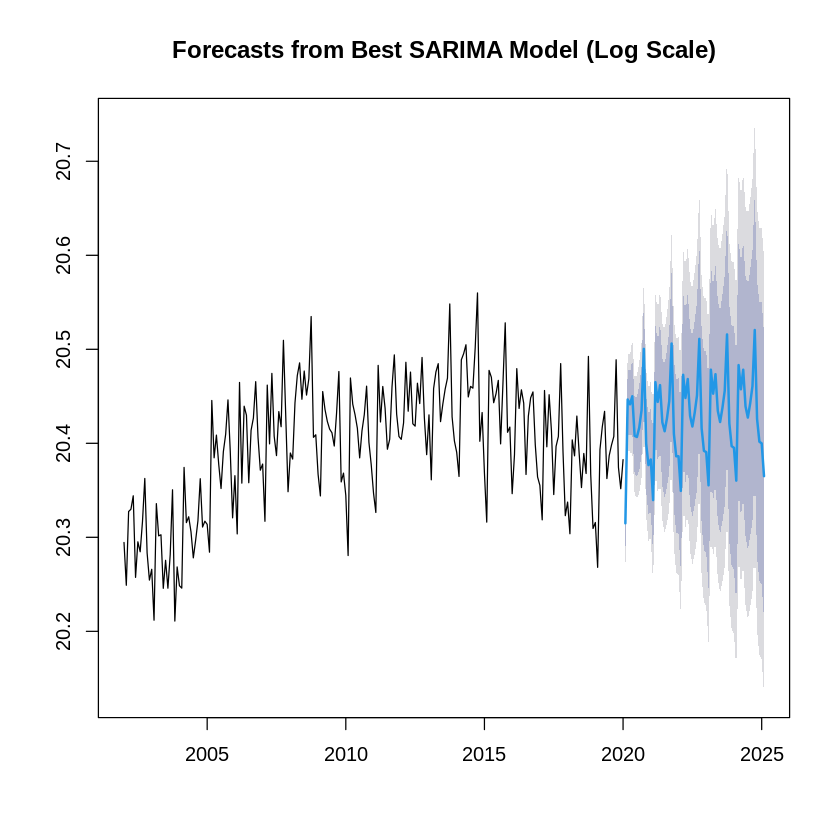

In [ ]:
# Plot forecasts in log scale
plot(forecasts, main = "Forecasts from Best SARIMA Model (Log Scale)")

#### Back-transform forecasts

In [ ]:
# Back-transform forecasts and prediction intervals
back_transformed_forecasts <- exp(forecasts$mean)
back_transformed_lower <- exp(forecasts$lower[,2])  # 95% interval
back_transformed_upper <- exp(forecasts$upper[,2])  # 95% interval

In [ ]:
# Create a time series object for the back-transformed forecasts
ts_forecasts <- ts(back_transformed_forecasts, start = c(2020, 2), frequency = 12)
ts_lower <- ts(back_transformed_lower, start = c(2020, 2), frequency = 12)
ts_upper <- ts(back_transformed_upper, start = c(2020, 2), frequency = 12)

#### Plotting Predictions

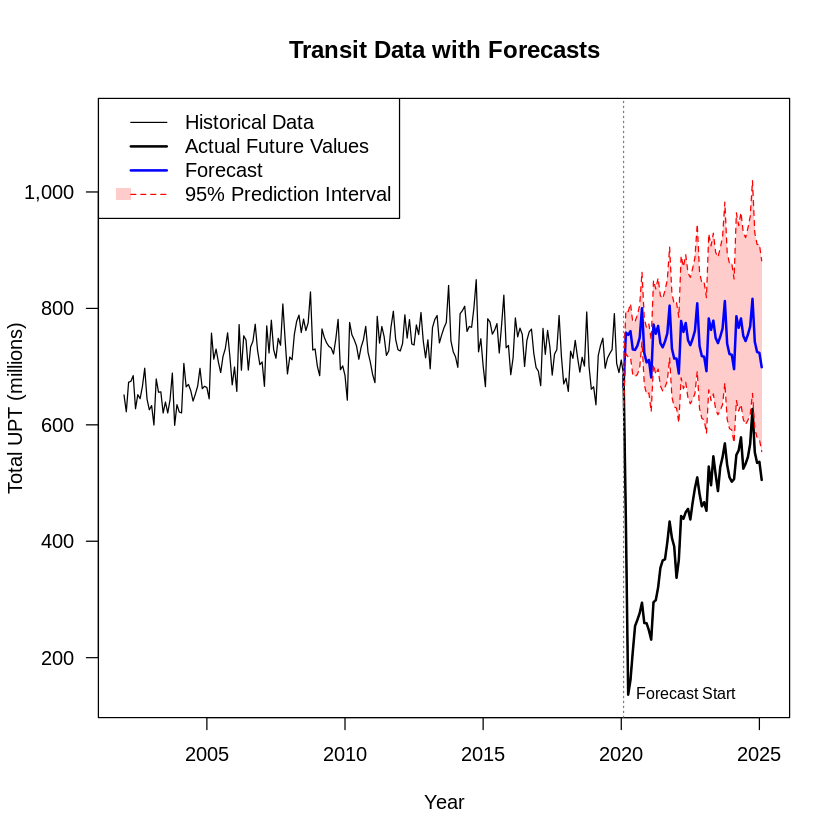

In [ ]:
# Plot original data with forecasts
par(mfrow = c(1, 1))
plot(transit.t, xlim = c(2002, (2025+1/6)), ylim = c(min(transit.t), max(ts_upper)*1.1),
     main = "Transit Data with Forecasts",
     xlab = "Year", ylab = "Total UPT (millions)",
      yaxt = "n") # Suppress y-axis

# Add custom y-axis
axis(2, at = axTicks(2),
     labels = format(axTicks(2)/1000000, big.mark = ","),
     las = 1)
# Shade the prediction interval region
polygon(c(time(ts_lower), rev(time(ts_upper))),
        c(as.numeric(ts_lower), rev(as.numeric(ts_upper))),
        col = rgb(1, 0, 0, 0.2), border = NA)

# Add forecast and actual lines
lines(ts_forecasts, col = "blue", lwd = 2)
lines(window(transit.t, start = c(2020, 2)), col = "black", lwd = 2)
lines(ts_lower, col = "red", lty = 2)
lines(ts_upper, col = "red", lty = 2)

# Add vertical line to separate training data from forecast period
abline(v = 2020 + 1/12, lty = 3, col = "gray50")
text(2020 + 1/12, min(transit.t), "Forecast Start", pos = 4, cex = 0.8)

# Add legend
legend("topleft", legend = c("Historical Data", "Actual Future Values", "Forecast", "95% Prediction Interval"),
       col = c("black", "black", "blue", "red"),
       lty = c(1, 1, 1, 2),
       lwd = c(1, 2, 2, 1),
       fill = c(NA, NA, NA, rgb(1, 0, 0, 0.2)),
       border = c(NA, NA, NA, NA))


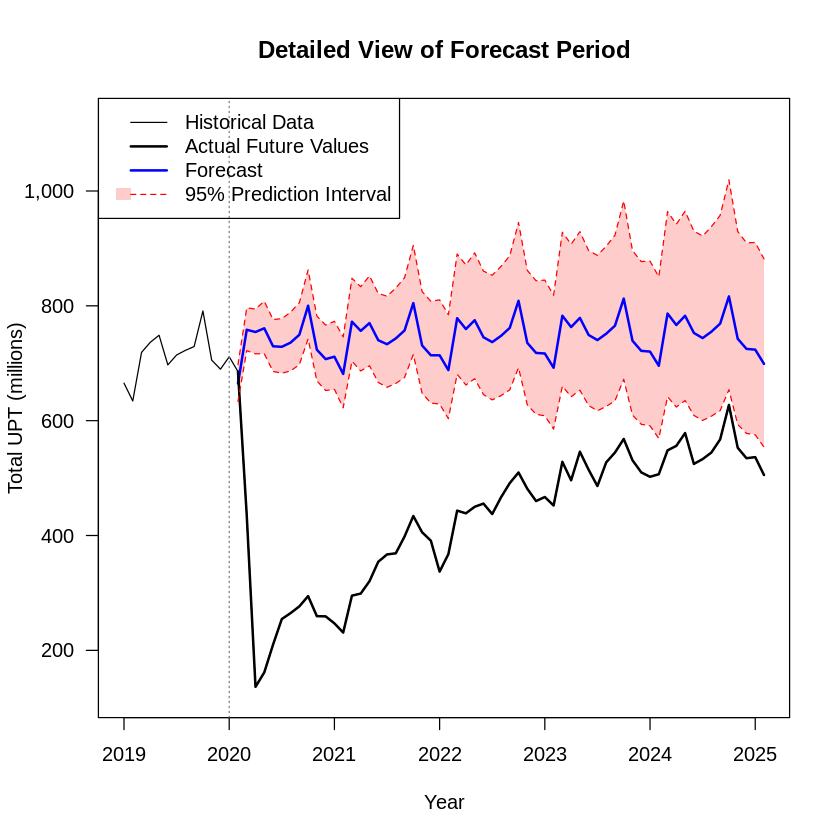

In [ ]:
# Add a focused view of the forecast period
forecast_window <- window(transit.t, start = c(2019, 1))
forecast_period <- window(transit.t, start = c(2020, 2))

par(mfrow = c(1, 1))
plot(forecast_window, main = "Detailed View of Forecast Period",
     xlab = "Year", ylab = "Total UPT (millions)",
      yaxt = "n",
        ylim = c(min(c(ts_lower, forecast_period))*0.9, max(c(ts_upper, forecast_period))*1.1))
# Shade the prediction interval region
polygon(c(time(ts_lower), rev(time(ts_upper))),
        c(as.numeric(ts_lower), rev(as.numeric(ts_upper))),
        col = rgb(1, 0, 0, 0.2), border = NA)

# Add custom y-axis
axis(2, at = axTicks(2),
     labels = format(axTicks(2)/1000000, big.mark = ","),
     las = 1)

# Add forecast and actual lines
lines(ts_forecasts, col = "blue", lwd = 2)
lines(forecast_period, col = "black", lwd = 2)
lines(ts_lower, col = "red", lty = 2)
lines(ts_upper, col = "red", lty = 2)

# Add vertical line to separate training data from forecast period
abline(v = 2020, lty = 3, col = "gray50")

# Add legend
legend("topleft", legend = c("Historical Data", "Actual Future Values", "Forecast", "95% Prediction Interval"),
       col = c("black", "black", "blue", "red"),
       lty = c(1, 1, 1, 2),
       lwd = c(1, 2, 2, 1),
       fill = c(NA, NA, NA, rgb(1, 0, 0, 0.2)),
       border = c(NA, NA, NA, NA))


#### Error

In [ ]:
forecast_table <- data.frame(
  Month = rep(month.abb, length.out = length(ts_forecasts)),  # Repeat month names to match length
  Actual = round(as.numeric(window(transit.t, start = c(2020,2))), 2),
  Forecast = round(as.numeric(ts_forecasts), 2),
  Lower_95 = round(as.numeric(ts_lower), 2),
  Upper_95 = round(as.numeric(ts_upper), 2)
)


forecast_table$Estimated_Loss <- round(forecast_table$Actual - forecast_table$Forecast, 2)

forecast_table$Percentage_Loss <- ifelse(forecast_table$Forecast != 0,
                                         round((forecast_table$Estimated_Loss / forecast_table$Forecast) * 100, 1),
                                         NA)
forecast_table$Actual_Below_LowerPI <- forecast_table$Actual < forecast_table$Lower_95
forecast_table$Loss_Below_PI95 <- ifelse(forecast_table$Actual_Below_LowerPI,
                                         round(forecast_table$Lower_95 - forecast_table$Actual, 2),
                                         0)
forecast_table$Cumulative_Loss <- cumsum(forecast_table$Estimated_Loss)

forecast_table$Time_Index <- 1:nrow(forecast_table)


# Pretty print the forecast table
kable_if_available <- function(table) {
  if (requireNamespace("knitr", quietly = TRUE)) {
    return(knitr::kable(table, format = "markdown", digits = 2))
  } else {
    return(table)
  }
}
forecast_table <- forecast_table %>%
  filter(Time_Index != 1)

In [ ]:
print(kable_if_available(forecast_table))



|Month |    Actual|  Forecast|  Lower_95|   Upper_95| Estimated_Loss| Percentage_Loss|Actual_Below_LowerPI | Loss_Below_PI95| Cumulative_Loss| Time_Index|
|:-----|---------:|---------:|---------:|----------:|--------------:|---------------:|:--------------------|---------------:|---------------:|----------:|
|Feb   | 435190913| 758313565| 721941667|  796517902|     -323122652|           -42.6|TRUE                 |       286750754|      -302380256|          2|
|Mar   | 136447239| 754426236| 716440388|  794426103|     -617978997|           -81.9|TRUE                 |       579993149|      -920359253|          3|
|Apr   | 161587333| 760916323| 716557892|  808020756|     -599328990|           -78.8|TRUE                 |       554970559|     -1519688242|          4|
|May   | 209935553| 729549130| 685714898|  776185459|     -519613577|           -71.2|TRUE                 |       475779345|     -2039301819|          5|
|Jun   | 254497029| 728658331| 682696811|  777714140|     -474161302

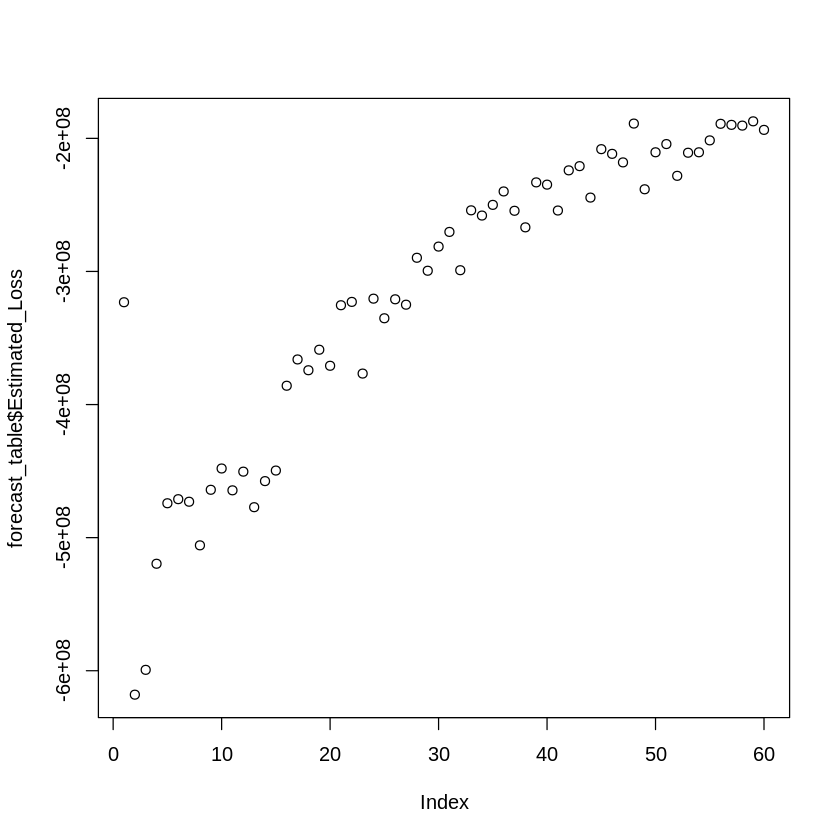

In [ ]:
plot(forecast_table$Estimated_Loss)

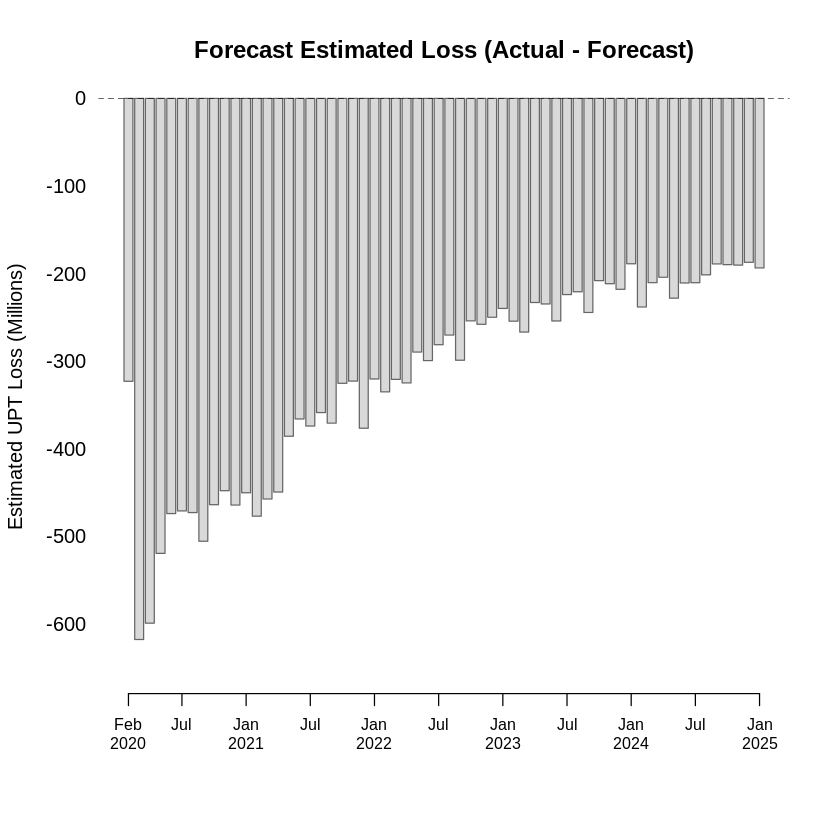

In [ ]:
num_bars_plot <- nrow(forecast_table)
start_date_plot <- as.Date("2020-02-01")
date_sequence_plot <- seq.Date(from = start_date_plot, by = "month", length.out = num_bars_plot)

x_axis_labels_plot_full <- character(num_bars_plot)
for (i in 1:num_bars_plot) {
  current_date <- date_sequence_plot[i]
  month_num <- as.integer(format(current_date, "%m"))
  month_abb_str <- format(current_date, "%b")
  year_str <- format(current_date, "%Y")

  if (i == 1 && format(current_date, "%Y-%m") == "2020-02") {
    #  First label is Feb 2020
    x_axis_labels_plot_full[i] <- paste0(month_abb_str, "\n", year_str)
  } else if (month_num == 1) {
    x_axis_labels_plot_full[i] <- paste0("Jan\n", year_str)
  } else if (month_num == 7) {
    x_axis_labels_plot_full[i] <- "Jul\n "
  }
}

old_par <- par(no.readonly = TRUE)
par(mfrow = c(1, 1),
    bg = "white",
    mar = c(6.1, 4.1, 4.1, 2.1)
)

bar_centers <- barplot(forecast_table$Estimated_Loss,
                       main = "Forecast Estimated Loss (Actual - Forecast)",
                       ylab = "Estimated UPT Loss (Millions)",
                       yaxt = "n",
                       xaxt = "n",
                       col = "grey85",
                       border = "grey40",
                       ylim = c(min(0, min(forecast_table$Estimated_Loss, na.rm = TRUE)) * 1.1,
                                max(0, max(forecast_table$Estimated_Loss, na.rm = TRUE)) * 1.1),
                       col.main = "black",
                       col.lab = "black"
)

y_ticks_locations <- axTicks(2)
axis(side = 2,
     at = y_ticks_locations,
     labels = format(y_ticks_locations / 1000000, big.mark = ",", scientific = FALSE),
     las = 1,
     tick = FALSE,
     col.axis = "black",
     line = -0.5
)

label_indices <- which(x_axis_labels_plot_full != "")
tick_positions_for_x <- bar_centers[label_indices]
actual_labels_for_x <- x_axis_labels_plot_full[label_indices]

if (length(tick_positions_for_x) > 0) {
  axis(side = 1,
       at = tick_positions_for_x,
       labels = actual_labels_for_x,
       tick = TRUE,
       las = 1,
       mgp = c(3, 1.5, 0),
       col.axis = "black",
       col.ticks = "black",
       cex.axis = 0.8
  )
} else {
  warning("No labels were generated for the x-axis.")
}
abline(h = 0, lty = 2, col = "black")


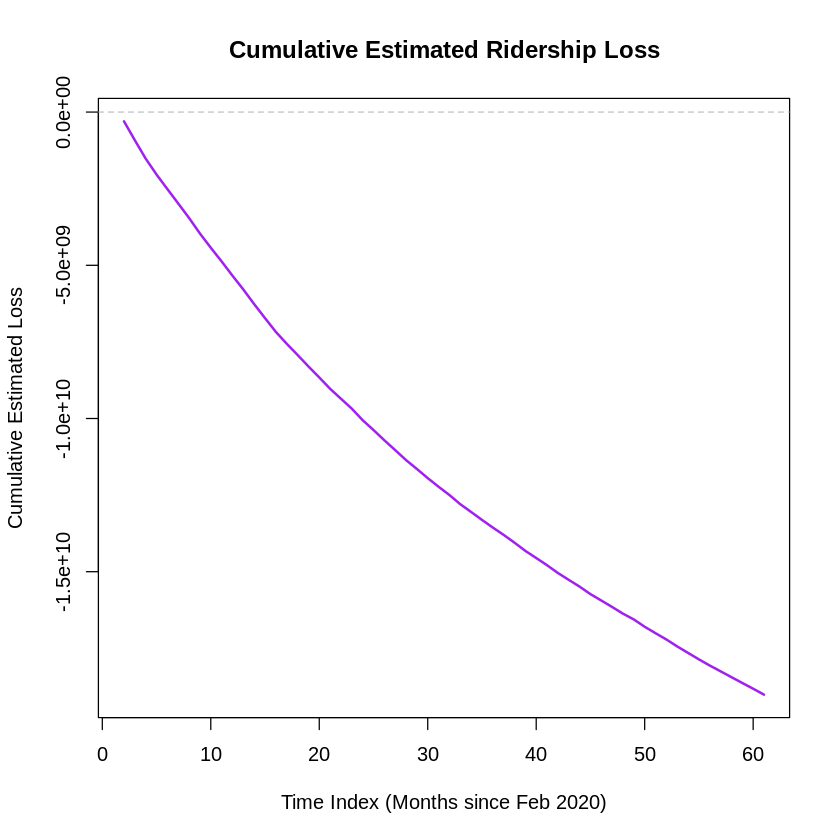

In [ ]:
plot_title <- "Cumulative Estimated Ridership Loss"
# Create the plot showing cumulative trend
plot(forecast_table$Time_Index, forecast_table$Cumulative_Loss, type = 'l', col = 'purple', lwd = 2,
     xlab = "Time Index (Months since Feb 2020)", ylab = "Cumulative Estimated Loss",
     main = plot_title)
# Add reference line at zero loss
abline(h = 0, col = 'grey', lty=2)

In [ ]:
total_estimated_loss <- sum(forecast_table$Estimated_Loss, na.rm = TRUE)
print(paste("Total Estimated Loss:", round(total_estimated_loss, 2)))
months_below_PI <- sum(forecast_table$Actual_Below_LowerPI, na.rm = TRUE)
print(paste("Months Actual Below 95% Lower PI:", months_below_PI, "out of", length(forecast_table$Time_Index)))

[1] "Total Estimated Loss: -19032777254"
[1] "Months Actual Below 95% Lower PI: 60 out of 60"


## Intervention Model

In [ ]:
transit.l.t.train <- window(transit.l.t, end = c(2024,2))
 # Model fitting - try different SARIMA models
n <- length(transit.l.t.train)
# Model fitting - try different SARIMA models
covid <- rep(0, n)
# Find COVID period (Feb 2020 onward - permanent effect)
t <- time(transit.l.t.train)
start_idx <- which(t >= 2020.16666)[1]  # Feb 2020
covid[start_idx:n] <- 1


# Model 1: SARIMA(1,1,1)(1,1,1)12
model1_int <- Arima(transit.l.t.train, order = c(1,1,1), seasonal = c(1,1,1), xreg=covid,
                          method="CSS-ML")
# Model 2: SARIMA(0,1,1)(0,1,1)12
model2_int <- Arima(transit.l.t.train, order = c(0,1,1), seasonal = c(0,1,1), xreg=covid,
                          method="CSS-ML")
# Model 3: SARIMA(1,1,0)(1,1,0)12
model3_int <- Arima(transit.l.t.train, order = c(1,1,0), seasonal = c(1,1,0), xreg=covid,
                          method="CSS-ML")
# Model 4: SARIMA(0,1,1)(1,1,0)12
model4_int <- Arima(transit.l.t.train, order = c(0,1,1), seasonal = c(1,1,0), xreg=covid,
                          method="CSS-ML")
# Model 5: SARIMA(1,1,0)(0,1,1)12
model5_int <- Arima(transit.l.t.train, order = c(1,1,0), seasonal = c(0,1,1), xreg=covid,
                          method="CSS-ML")
# Model 6: SARIMA(1,1,2)(0,1,1)12
model6_int <- Arima(transit.l.t.train, order = c(1,1,2), seasonal = c(0,1,1), xreg=covid,
                          method="CSS-ML")
# Model 7: SARIMA(1,1,3)(0,1,1)12
model7_int <- Arima(transit.l.t.train, order = c(1,1,3), seasonal = c(0,1,1), xreg=covid,
                          method="CSS-ML")

In [ ]:
models_int <- list(model1_int, model2_int, model3_int, model4_int, model5_int,model6_int,model7_int)
aicc_values_int <- sapply(models_int, function(model) model$aicc)

bic_values_int <- sapply(models_int, BIC)

model_comparison_int <- data.frame(
  Model = c("SARIMA(1,1,1)(1,1,1)12", "SARIMA(0,1,1)(0,1,1)12",
            "SARIMA(1,1,0)(1,1,0)12", "SARIMA(0,1,1)(1,1,0)12",
            "SARIMA(1,1,0)(0,1,1)12","SARIMA(1,1,2)(0,1,1)12","SARIMA(1,1,3)(0,1,1)12"),
  AICc = aicc_values_int,
  BIC = bic_values_int
)
print(model_comparison_int)

                   Model      AICc       BIC
1 SARIMA(1,1,1)(1,1,1)12 -540.8734 -520.0145
2 SARIMA(0,1,1)(0,1,1)12 -543.9698 -529.9975
3 SARIMA(1,1,0)(1,1,0)12 -430.3542 -416.3820
4 SARIMA(0,1,1)(1,1,0)12 -475.3337 -461.3614
5 SARIMA(1,1,0)(0,1,1)12 -512.6243 -498.6521
6 SARIMA(1,1,2)(0,1,1)12 -541.3026 -520.4437
7 SARIMA(1,1,3)(0,1,1)12 -575.0814 -550.8049


In [ ]:
# Choose the best model based on AICc
best_model_index_int <- which.min(aicc_values_int)
best_model_int <- models_int[[best_model_index_int]]
print(best_model_int)


Series: transit.l.t.train 
Regression with ARIMA(1,1,3)(0,1,1)[12] errors 

Coefficients:
         ar1      ma1     ma2     ma3     sma1     xreg
      0.9272  -1.7927  0.7463  0.1111  -0.9116  -1.3347
s.e.  0.0279   0.0701  0.1336  0.0719   0.0489   0.0227

sigma^2 = 0.00536:  log likelihood = 294.77
AIC=-575.54   AICc=-575.08   BIC=-550.8


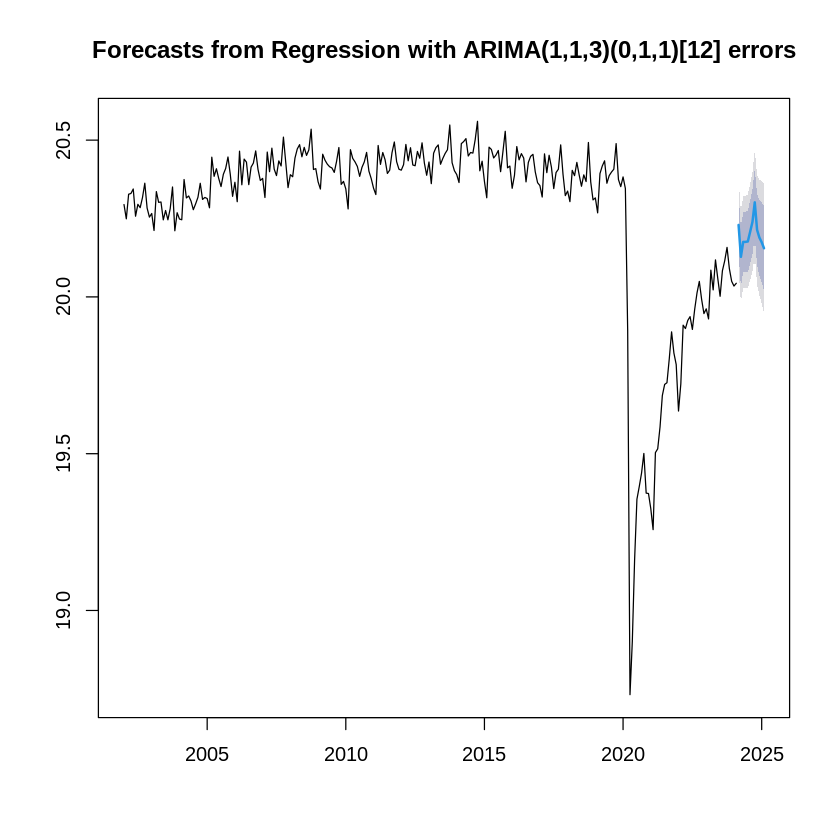

In [ ]:
forecast_covid <- rep(1,12)

intervention_forecast <- forecast(best_model_int, h = 12, xreg = forecast_covid)

plot(intervention_forecast)

### Model Diagnostics on the best model

In [ ]:
# Parameter significance for the best model
if (requireNamespace("lmtest", quietly = TRUE)) {
  coeftest <- lmtest::coeftest(best_model_int)
  print(coeftest)

  # Calculate 95% confidence intervals manually
  coef_names <- rownames(coeftest)
  estimates <- coeftest[, 1]
  std_errors <- coeftest[, 2]

  conf_intervals <- data.frame(
    Parameter = coef_names,
    Estimate = estimates,
    StdError = std_errors,
    Lower_95 = estimates - 1.96 * std_errors,
    Upper_95 = estimates + 1.96 * std_errors
  )

  print(conf_intervals)
} else {
  # If lmtest is not available, use confint
  print(summary(best_model_int))
  cat("\n95% Confidence Intervals:\n")
  print(confint(best_model_int))
}


z test of coefficients:

      Estimate Std. Error  z value  Pr(>|z|)    
ar1   0.927175   0.027925  33.2019 < 2.2e-16 ***
ma1  -1.792668   0.070052 -25.5904 < 2.2e-16 ***
ma2   0.746307   0.133620   5.5853 2.333e-08 ***
ma3   0.111082   0.071949   1.5439    0.1226    
sma1 -0.911557   0.048945 -18.6241 < 2.2e-16 ***
xreg -1.334666   0.022692 -58.8156 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

     Parameter   Estimate   StdError    Lower_95   Upper_95
ar1        ar1  0.9271749 0.02792535  0.87244119  0.9819086
ma1        ma1 -1.7926682 0.07005238 -1.92997088 -1.6553655
ma2        ma2  0.7463069 0.13361975  0.48441217  1.0082016
ma3        ma3  0.1110820 0.07194864 -0.02993739  0.2521013
sma1      sma1 -0.9115566 0.04894495 -1.00748868 -0.8156245
xreg      xreg -1.3346661 0.02269239 -1.37914322 -1.2901890



	Ljung-Box test

data:  Residuals from Regression with ARIMA(1,1,3)(0,1,1)[12] errors
Q* = 11.677, df = 19, p-value = 0.8989

Model df: 5.   Total lags used: 24




	Box-Ljung test

data:  residuals(best_model_int)
X-squared = 11.677, df = 24, p-value = 0.9833


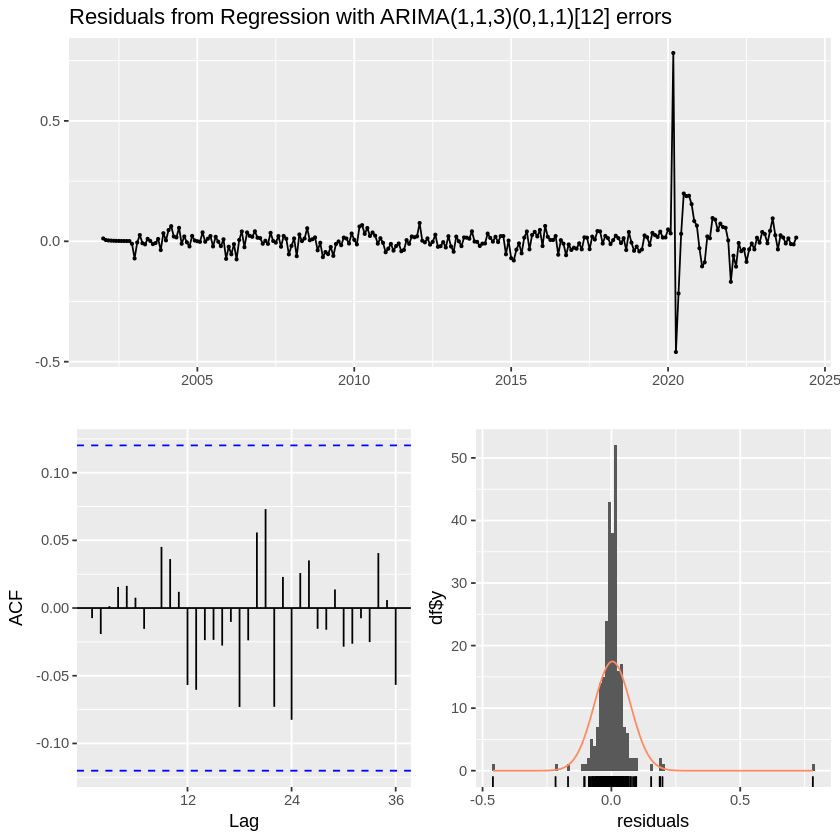

In [ ]:
# Residual analysis for the best model
par(mfrow = c(2, 2))
checkresiduals(best_model_int)

# Box-Ljung test for residual autocorrelation
Box.test(residuals(best_model_int), lag = 24, type = "Ljung-Box")

### Forecasting

In [ ]:
forecasts_int <- intervention_forecast


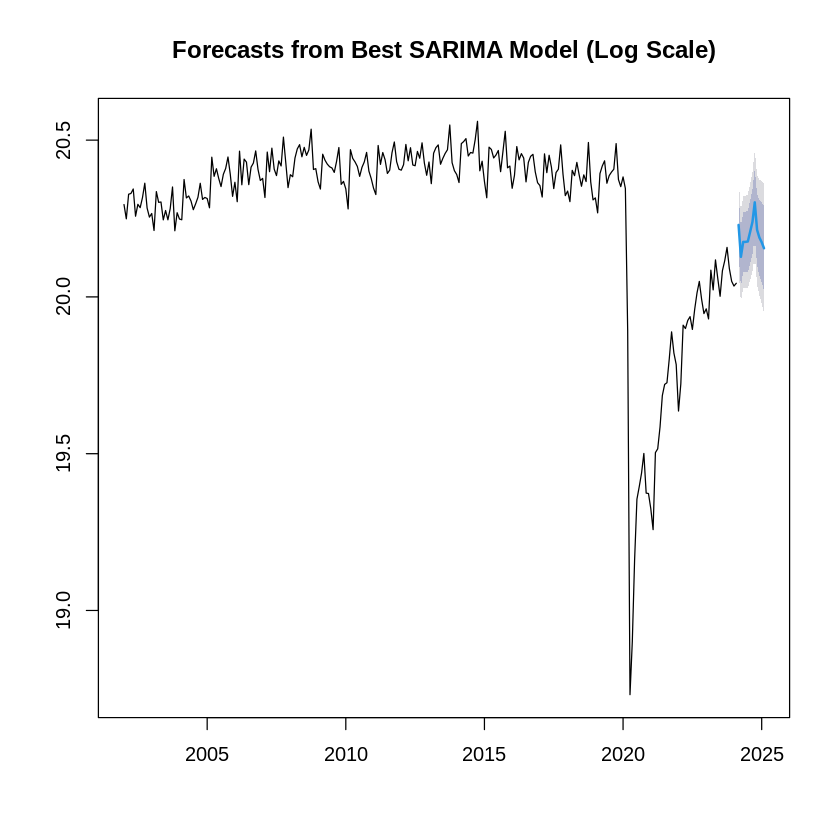

In [ ]:
# Plot forecasts in log scale
plot(forecasts_int, main = "Forecasts from Best SARIMA Model (Log Scale)")

#### Back-transform forecasts

In [ ]:
# Back-transform forecasts and prediction intervals
back_transformed_forecasts_int <- exp(forecasts_int$mean)
back_transformed_lower_int <- exp(forecasts_int$lower[,2])  # 95% interval
back_transformed_upper_int <- exp(forecasts_int$upper[,2])  # 95% interval

In [ ]:
# Create a time series object for the back-transformed forecasts
ts_forecasts_int <- ts(back_transformed_forecasts_int, start = c(2024, 3), frequency = 12)
ts_lower_int <- ts(back_transformed_lower_int, start = c(2024, 3), frequency = 12)
ts_upper_int <- ts(back_transformed_upper_int, start = c(2024, 3), frequency = 12)

#### Plotting Predictions

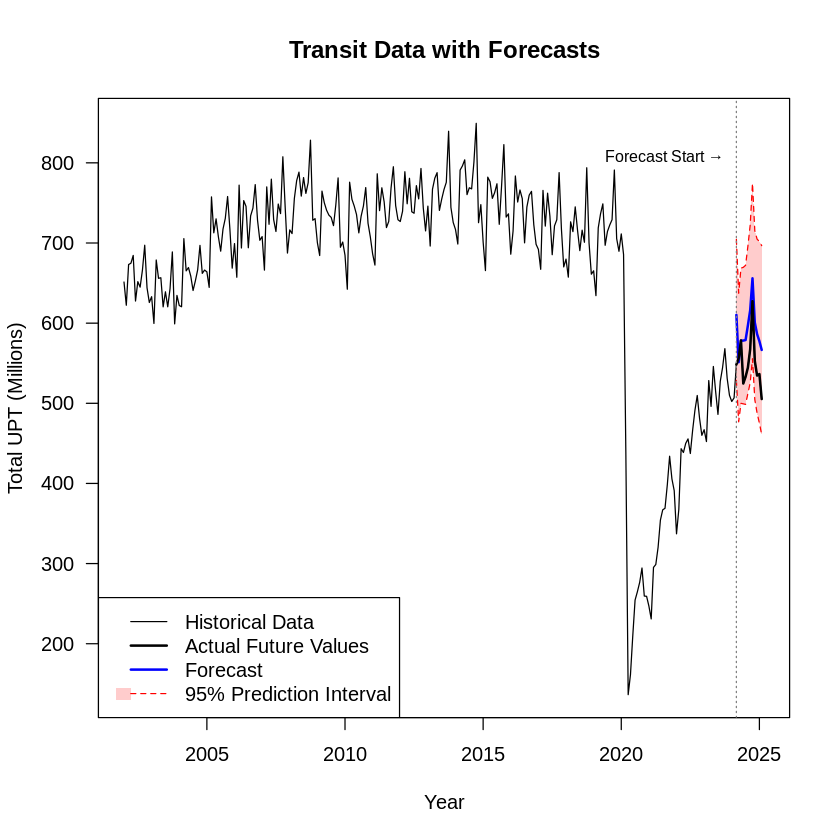

In [ ]:
# Plot original data with forecasts
par(mfrow = c(1, 1))
plot(transit.t, xlim = c(2002, 2025.16667), ylim = c(min(transit.t), max(ts_upper_int)*1.1),
     main = "Transit Data with Forecasts",
     xlab = "Year", ylab = "Total UPT (Millions)",          yaxt = "n") # Suppress y-axis

# Add custom y-axis
axis(2, at = axTicks(2),
     labels = format(axTicks(2)/1000000, big.mark = ","),
     las = 1)

# Shade the prediction interval region
polygon(c(time(ts_lower_int), rev(time(ts_upper_int))),
        c(as.numeric(ts_lower_int), rev(as.numeric(ts_upper_int))),
        col = rgb(1, 0, 0, 0.2), border = NA)

# Add forecast and actual lines
lines(ts_forecasts_int, col = "blue", lwd = 2)
lines(window(transit.t, start = c(2024, 3)), col = "black", lwd = 2)
lines(ts_lower_int, col = "red", lty = 2)
lines(ts_upper_int, col = "red", lty = 2)

# Add vertical line to separate training data from forecast period
abline(v = 2024 + 1/6, lty = 3, col = "gray50")  # February 2024
text(2024 + 1/6, min(ts_lower_int * 1.75), "Forecast Start →", pos = 2, cex = 0.8)



# Add legend
legend("bottomleft", legend = c("Historical Data", "Actual Future Values", "Forecast", "95% Prediction Interval"),
       col = c("black", "black", "blue", "red"),
       lty = c(1, 1, 1, 2),
       lwd = c(1, 2, 2, 1),
       fill = c(NA, NA, NA, rgb(1, 0, 0, 0.2)),
       border = c(NA, NA, NA, NA))


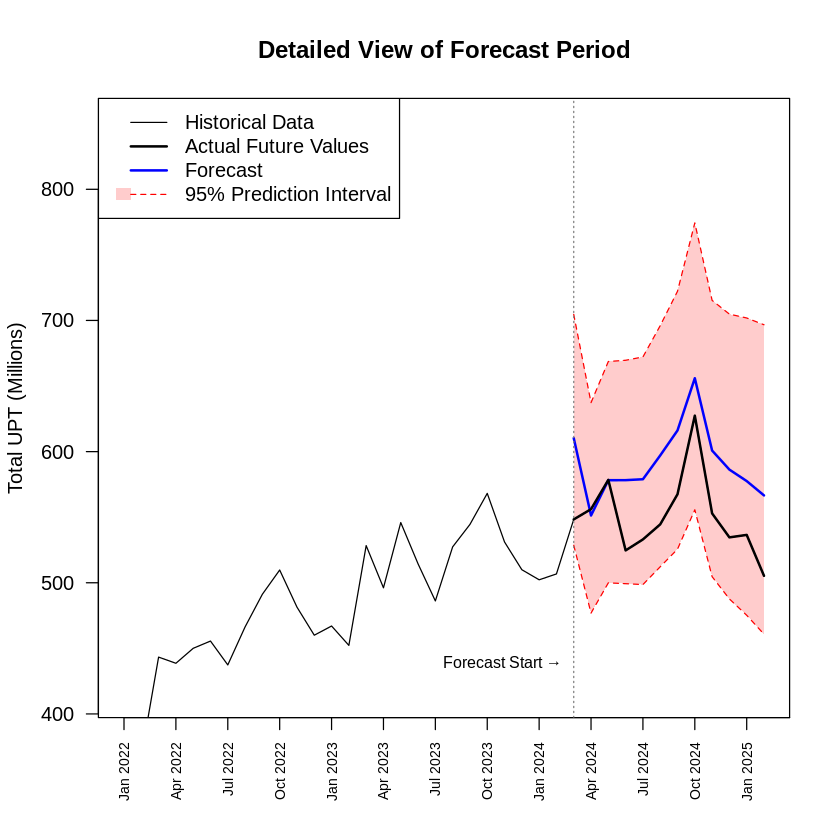

In [ ]:
# Add a focused view of the forecast period
forecast_window <- window(transit.t, start = c(2022, 1))
forecast_period <- window(transit.t, start = c(2024, 3))

par(mfrow = c(1, 1))
plot(forecast_window, main = "Detailed View of Forecast Period",
     xlab = "", ylab = "Total UPT (Millions)", xaxt = "n",  # Suppress default x-axis
     ylim = c(min(c(ts_lower_int, forecast_period))*0.9, max(c(ts_upper_int, forecast_period))*1.1),          yaxt = "n") # Suppress y-axis

# Add custom y-axis
axis(2, at = axTicks(2),
     labels = format(axTicks(2)/1000000, big.mark = ","),
     las = 1)

# Create custom x-axis with month-year labels
quarter_points <- seq(2022, 2025.25, by = 0.25)  # Quarterly points
month_labels <- c()

for(t in quarter_points) {
  year <- floor(t)
  month_num <- floor(((t %% 1) * 12) + 1)
  month_name <- month.abb[month_num]
  month_labels <- c(month_labels, paste(month_name, year))
}

axis(1, at = quarter_points, labels = month_labels, las = 2, cex.axis = 0.7)

# Shade the prediction interval region
polygon(c(time(ts_lower_int), rev(time(ts_upper_int))),
        c(as.numeric(ts_lower_int), rev(as.numeric(ts_upper_int))),
        col = rgb(1, 0, 0, 0.2), border = NA)

# Add forecast and actual lines
lines(ts_forecasts_int, col = "blue", lwd = 2)
lines(forecast_period, col = "black", lwd = 2)
lines(ts_lower_int, col = "red", lty = 2)
lines(ts_upper_int, col = "red", lty = 2)
# Add vertical line to separate training data from forecast period
abline(v = 2024 + 1/6, lty = 3, col = "gray50")  # February 2024
text(2024 + 1/6, min(ts_lower_int)*0.95, "Forecast Start →", pos = 2, cex = 0.8)


# Add legend
legend("topleft", legend = c("Historical Data", "Actual Future Values", "Forecast", "95% Prediction Interval"),
       col = c("black", "black", "blue", "red"),
       lty = c(1, 1, 1, 2),
       lwd = c(1, 2, 2, 1),
       fill = c(NA, NA, NA, rgb(1, 0, 0, 0.2)),
       border = c(NA, NA, NA, NA))

In [ ]:
# Define prediction period
holdout_period <- window(transit.t, start=c(2024,3), end=c(2025,2))

# Calculate accuracy metrics
# Calculate percentage errors
mape_original <- mean(abs((holdout_period - ts_forecasts_int) / holdout_period * 100))

# Convert to millions and calculate RMSE and MAE
rmse_original <- sqrt(mean((holdout_period - ts_forecasts_int)^2)) / 1e6
mae_original <- mean(abs(holdout_period - ts_forecasts_int)) / 1e6

# Display results
metrics_original <- data.frame(
  Metric = c("MAPE (%)", "RMSE (Millions)", "MAE (Millions)"),
  Value = c(round(mape_original, 2), round(rmse_original,2), round(mae_original,2))
)

print(metrics_original)

           Metric Value
1        MAPE (%)  7.66
2 RMSE (Millions) 45.81
3  MAE (Millions) 41.51


# Automated Model Building

In [ ]:
# CAN TAKE A WHILE TO RUN WITHOUT FAST HARDWARE, REFER TO NEXT BLOCK TO DOWNLOAD FROM GITHUB
#  ARIMA model fitting function with diagnostic validation
fit_arima_both <- function(ntd_id, transit.complete, lag_check = 24, max_total_params = 5) {
  start_time <- Sys.time()

  # Filter data for the selected jurisdiction
  jur_data <- transit.complete %>%
    filter(NTD.ID == as.character(ntd_id)) %>%
    arrange(date)

  # Create time series object
  ts_data <- ts(jur_data$log.UPT.sum,
                start = c(2002, 1),
                frequency = 12)

  # Create the pre-COVID time series object (up to Jan 2020)
  end_pre_covid <- c(2020, 1)
  ts_pre_covid <- window(ts_data, end = end_pre_covid)

  # Prepare COVID dummy variable for the interruption model
  n_full <- length(ts_data)
  covid_dummy <- rep(0, n_full)

  # Pull out time info and set the start index for COVID
  time_full <- time(ts_data)
  start_idx_covid <- which(time_full >= 2020.16666)[1]  # Feb 2020
  if (!is.na(start_idx_covid) && start_idx_covid <= n_full) {
    covid_dummy[start_idx_covid:n_full] <- 1
  }

  # Function to check if residuals pass Ljung-Box test
  passes_ljung_box <- function(model, lag = lag_check) {
    if(is.null(model)) return(FALSE)

    # Suppress output from checkresiduals
    invisible(capture.output({
      # Use checkresiduals with plot off
      test_result <- checkresiduals(model, lag = lag, plot = FALSE)
    }))

    # Return TRUE if p-value > 0.05, residuals are white noise
    return(test_result$p.value > 0.05)
  }

  # Track models
  pre_covid_candidates <- list()
  interruption_candidates <- list()
  models_tried <- 0

  # Parameter limits
  max_p <- 5
  max_q <- 5
  max_P <- 2
  max_Q <- 2

  # First: Collect all candidate models with their AICc
  for(p in 0:max_p) {
    for(q in 0:max_q) {
      for(P in 0:max_P) {
        for(Q in 0:max_Q) {
          # Check if the total number of parameters is within the limit
          if ((p + q + P + Q) <= max_total_params) {
            models_tried <- models_tried + 1
            current_model_name <- paste0("Arima(", p, ",1,", q, ")(", P, ",1,", Q, ")[12]")

            # Fit Pre-COVID Model
            tryCatch({
              model_pre <- Arima(ts_pre_covid, order = c(p, 1, q),
                                 seasonal = list(order = c(P, 1, Q), period = 12),
                                 method = "CSS-ML")

              current_aicc_pre <- model_pre$aicc
              if(!is.na(current_aicc_pre)) {
                pre_covid_candidates[[length(pre_covid_candidates) + 1]] <- list(
                  model = model_pre,
                  name = current_model_name,
                  aicc = current_aicc_pre,
                  params = c(p=p, q=q, P=P, Q=Q)
                )
              }
            }, error = function(e) {})

            # Fit Intervention Model
            tryCatch({
              model_inter <- Arima(ts_data, order = c(p, 1, q),
                                   seasonal = list(order = c(P, 1, Q), period = 12),
                                   xreg = covid_dummy,
                                   method = "CSS-ML")

              current_aicc_inter <- model_inter$aicc
              if(!is.na(current_aicc_inter)) {
                interruption_candidates[[length(interruption_candidates) + 1]] <- list(
                  model = model_inter,
                  name = current_model_name,
                  aicc = current_aicc_inter,
                  params = c(p=p, q=q, P=P, Q=Q)
                )
              }
            }, error = function(e) {  })
          }
        }
      }
    }
  }

  # If we have no candidates, return NULL models (shouldnt happen but for robustness)
  if(length(pre_covid_candidates) == 0 || length(interruption_candidates) == 0) {
    end_time <- Sys.time()
    elapsed <- difftime(end_time, start_time, units = "secs")
    print(paste("Time Elapsed: ", elapsed, "seconds - No valid models found"))

    return(list(
      pre_covid = list(model = NULL, name = NULL, aicc = Inf, passes_lb = FALSE),
      interruption = list(model = NULL, name = NULL, aicc = Inf, passes_lb = FALSE),
      models_tried = models_tried,
      time_taken = elapsed
    ))
  }

  # Sort models by AICc (lowest first)
  pre_covid_candidates <- pre_covid_candidates[order(sapply(pre_covid_candidates, function(x) x$aicc))]
  interruption_candidates <- interruption_candidates[order(sapply(interruption_candidates, function(x) x$aicc))]

  # Show top 5 models by AICc
  cat("\nTop 5 intervention models by AICc for NTD.ID", ntd_id, ":\n")
  for (i in 1:min(5, length(interruption_candidates))) {
    p <- interruption_candidates[[i]]$params["p"]
    q <- interruption_candidates[[i]]$params["q"]
    P <- interruption_candidates[[i]]$params["P"]
    Q <- interruption_candidates[[i]]$params["Q"]
    cat(sprintf("ARIMA(%d,1,%d)(%d,1,%d)[12]: AICc = %.4f\n",
                p, q, P, Q,
                interruption_candidates[[i]]$aicc))
  }


  # Start testing models in AICc order until one passes Ljung-Box
  best_pre_model <- NULL
  best_pre_name <- NULL
  best_pre_aicc <- Inf
  pre_passes_lb <- FALSE

  best_inter_model <- NULL
  best_inter_name <- NULL
  best_inter_aicc <- Inf
  inter_passes_lb <- FALSE

  # For pre-COVID models, test in AICc order until one passes
  # Store the first model as fallback
  if(length(pre_covid_candidates) > 0) {
    best_pre_model <- pre_covid_candidates[[1]]$model
    best_pre_name <- pre_covid_candidates[[1]]$name
    best_pre_aicc <- pre_covid_candidates[[1]]$aicc

    # Test models in order until one passes
    for(i in 1:length(pre_covid_candidates)) {
      model <- pre_covid_candidates[[i]]$model

      # Ljung-Box test
      lb_test_result <- passes_ljung_box(model)
      if(lb_test_result) {
        # Found a model that passes the test
        best_pre_model <- model
        best_pre_name <- pre_covid_candidates[[i]]$name
        best_pre_aicc <- pre_covid_candidates[[i]]$aicc
        pre_passes_lb <- TRUE
        break  # Early stopping once we find a passing model
      }
    }
  }

  # Store the first model as fallback
  if(length(interruption_candidates) > 0) {
    best_inter_model <- interruption_candidates[[1]]$model
    best_inter_name <- interruption_candidates[[1]]$name
    best_inter_aicc <- interruption_candidates[[1]]$aicc

    # Test all models in order until one passes
    for(i in 1:length(interruption_candidates)) {
      model <- interruption_candidates[[i]]$model

      # Ljung-Box test
      lb_test_result <- passes_ljung_box(model)
      if(lb_test_result) {
        # Found a model that passes the test
        best_inter_model <- model
        best_inter_name <- interruption_candidates[[i]]$name
        best_inter_aicc <- interruption_candidates[[i]]$aicc
        inter_passes_lb <- TRUE
        break  # Early stopping once we find a passing model
      }
    }
  }

  end_time <- Sys.time()
  elapsed <- difftime(end_time, start_time, units = "secs")
  print(paste("Time Elapsed: ", elapsed, "seconds"))

  # Return results with diagnostics
  return(list(
    pre_covid = list(
      model = best_pre_model,
      name = best_pre_name,
      aicc = best_pre_aicc,
      passes_lb = pre_passes_lb
    ),
    interruption = list(
      model = best_inter_model,
      name = best_inter_name,
      aicc = best_inter_aicc,
      passes_lb = inter_passes_lb
    ),
    candidates_tried_pre = length(pre_covid_candidates),
    candidates_tried_inter = length(interruption_candidates),
    models_tried = models_tried,
    time_taken = elapsed
  ))
}

# Remove last year of data
transit.complete.train <- transit.complete %>%
  filter(date < as.Date("2024-03-01"))

# Set up parallel processing
# Use all available cores - 2
plan(multisession, workers = availableCores() - 2)

# Fit all complete jurisdictions
ids_to_process <- complete.jurisdictions$NTD.ID
start_train_time <- Sys.time()

# Parallel map
model_results <- future_map(
  ids_to_process,
  ~fit_arima_both_improved(ntd_id = .x, transit.complete = transit.complete.train),
  .progress = TRUE
)

# Set names
names(model_results) <- as.character(ids_to_process)
end_train_time <- Sys.time()

# Calculate how long training took
total_train_elapsed <- difftime(end_train_time, start_train_time, units = "secs")
print(paste("Training finished in", round(total_train_elapsed, 1), "seconds."))


In [ ]:
file_url <- "https://github.com/elivatsaas/sta477-final-project/raw/62ef93e583b1235c167c3acf332e5999cf87b567/individual_jur_models.rds"
options( download.file.method="curl", download.file.extra="-k -L" )
download.file( file_url, "individual_jur_models.rds" )
individual_jur_models <- readRDS("individual_jur_models.rds")

In [ ]:
# Extract ARIMA orders from model name
extract_arima_orders <- function(model_name) {
  if(is.null(model_name)) return(NULL)

  # Parse ARIMA(p,d,q)(P,D,Q)[12] format
  pattern <- "ARIMA\\((\\d+),(\\d+),(\\d+)\\)\\((\\d+),(\\d+),(\\d+)\\)"
  matches <- regmatches(model_name, regexec(pattern, model_name))

  if(length(matches[[1]]) > 0) {
    return(list(
      p = as.integer(matches[[1]][2]),
      q = as.integer(matches[[1]][4]),
      P = as.integer(matches[[1]][5]),
      Q = as.integer(matches[[1]][7])
    ))
  }
  return(NULL)
}

# Calculate total number of parameters
calculate_parameters <- function(orders) {
  if(is.null(orders)) return(NA)
  # Total parameters = p + q + P + Q (excluding d and D)
  return(orders$p + orders$q + orders$P + orders$Q)
}

# Get IDs where both models fit successfully (should be all 197)
fully_successful_ids <- names(model_results)[sapply(model_results, function(x) {
  !is.null(x$pre_covid$model) && !is.null(x$interruption$model)
})]

# Create data frames for orders and parameters
pre_orders_df <- data.frame()
inter_orders_df <- data.frame()
pre_params_count <- c()
inter_params_count <- c()

# Extract orders for each successful ID
for(id in fully_successful_ids) {
  result <- model_results[[id]]

  # Extract pre-COVID orders
  pre_orders <- extract_arima_orders(result$pre_covid$name)
  if(!is.null(pre_orders)) {
    pre_orders_df <- rbind(pre_orders_df,
                           data.frame(p = pre_orders$p, q = pre_orders$q,
                                      P = pre_orders$P, Q = pre_orders$Q))
    pre_params_count <- c(pre_params_count, calculate_parameters(pre_orders))
  }

  # Extract intervention orders
  inter_orders <- extract_arima_orders(result$interruption$name)
  if(!is.null(inter_orders)) {
    inter_orders_df <- rbind(inter_orders_df,
                             data.frame(p = inter_orders$p, q = inter_orders$q,
                                        P = inter_orders$P, Q = inter_orders$Q))
    inter_params_count <- c(inter_params_count, calculate_parameters(inter_orders))
  }
}

# Total jurisdictions
TOTAL_JURISDICTIONS <- length(ids_to_process)

# Parameters and their max values
params <- c("p", "q", "P", "Q", "p+q+P+Q")
max_orders <- list(p = 5, q = 5, P = 2, Q = 2, `p+q+P+Q` = 5)

# Add total params to the dataframes
pre_orders_df$`p+q+P+Q` <- pre_params_count
inter_orders_df$`p+q+P+Q` <- inter_params_count

# Row names
stat_rows_basic <- c("Min", "Q1", "Median", "Mean", "Q3", "Max")
stat_rows_pct <- paste0("Equals ", 0:5, " \\%")
all_stat_rows <- c(stat_rows_basic, stat_rows_pct)

# Create empty summary data frames
pre_summary_df <- data.frame(matrix(NA, nrow = length(all_stat_rows), ncol = length(params)))
inter_summary_df <- data.frame(matrix(NA, nrow = length(all_stat_rows), ncol = length(params)))
rownames(pre_summary_df) <- rownames(inter_summary_df) <- all_stat_rows
colnames(pre_summary_df) <- colnames(inter_summary_df) <- params

# Function to process ARIMA orders for table
process_orders <- function(order_vector, param_name, N_total) {
  max_order <- max_orders[[param_name]]
  output <- rep(NA, length(all_stat_rows))
  names(output) <- all_stat_rows

  if (length(order_vector) > 0) {
    summ <- summary(order_vector)
    output["Min"] <- summ["Min."]
    output["Q1"] <- summ["1st Qu."]
    output["Median"] <- summ["Median"]
    output["Mean"] <- summ["Mean"]
    output["Q3"] <- summ["3rd Qu."]
    output["Max"] <- summ["Max."]

    # Calculate percentages
    if(param_name == "p+q+P+Q") {
      # For total_params, calculate percentages
      for (i in 0:5) {
        if(i <= 5) {
          output[paste0("Equals ", i, " \\%")] <- (sum(order_vector == i) / N_total) * 100
        }
      }
    } else {
      # For non total parameters
      freq <- table(factor(order_vector, levels = 0:max_order))
      for (i in 0:max_order) {
        output[paste0("Equals ", i, " \\%")] <- (freq[as.character(i)] / N_total) * 100
      }
    }
  }
  return(output)
}

# Fill summary data frames
for (param in params) {
  pre_summary_df[, param] <- process_orders(pre_orders_df[[param]], param, TOTAL_JURISDICTIONS)
  inter_summary_df[, param] <- process_orders(inter_orders_df[[param]], param, TOTAL_JURISDICTIONS)
}

# Combine both data frames
combined_summary_df <- cbind(pre_summary_df, inter_summary_df)

# Clean up empty rows
pct_rows <- grep("^Equals ", rownames(combined_summary_df))
keep_rows <- c(grep("^Equals ", rownames(combined_summary_df), invert = TRUE),
               pct_rows[rowSums(is.na(combined_summary_df[pct_rows, ])) < ncol(combined_summary_df)])
final_summary_df <- combined_summary_df[sort(keep_rows), , drop = FALSE]

# Set NA values to empty strings
options(knitr.kable.NA = '')

max_row <- which(rownames(final_summary_df) == "Max")

# Function to remove decimal places for whole numbers
format_numbers <- function(x) {
  if(is.na(x)) {
    return("")  # Return empty string for NA values
  } else if(is.numeric(x)) {
    # Check if x is a whole number
    if(abs(x - round(x)) < .Machine$double.eps^0.5) {
      return(sprintf("%.0f", x))  # Format as integer
    } else {
      return(sprintf("%.2f", x))  # Format with 2 decimal places
    }
  }
  return(x)
}

# Apply the formatting to the dataframe
for(i in 1:ncol(final_summary_df)) {
  final_summary_df[,i] <- sapply(final_summary_df[,i], format_numbers)
}

# Create table with kable
kable_output <- kable(final_summary_df, format = "latex",
                      caption = "Distribution of SARIMA Parameters Across 197 Transit Jurisdictions",
                      col.names = rep(params, 2),
                      booktabs = TRUE,
                      escape = FALSE,
                      na = "",
                      position = "!ht") %>%
  add_header_above(c(" " = 1,
                     "Pre-COVID Models" = 5,
                     "Intervention Models" = 5))

# Insert midline
latex_lines <- strsplit(kable_output, "\n")[[1]]
max_line_index <- grep("Max.*\\\\\\\\", latex_lines)
if(length(max_line_index) > 0) {
  latex_lines <- c(
    latex_lines[1:max_line_index],
    "\\midrule",
    latex_lines[(max_line_index+1):length(latex_lines)]
  )
  kable_output <- paste(latex_lines, collapse = "\n")
}

# Print the LaTeX
cat(kable_output)

# Print success rate (should be 100%)
success_rate <- (length(fully_successful_ids) / TOTAL_JURISDICTIONS) * 100
print(paste("Success rate:", round(success_rate, 1), "%"))
print(paste("Successful fits:", length(fully_successful_ids), "out of", TOTAL_JURISDICTIONS))

In [ ]:
# Cloropleth map construction
library(dplyr)
library(lubridate)
library(ggplot2)
library(sf)
library(tigris)
library(viridis)
library(forecast)

# Get US states boundaries
states_sf <- states(year = 2019, cb = TRUE) %>%
  filter(!STUSPS %in% c('AK', 'HI', 'PR', 'VI', 'GU', 'AS', 'MP'))

# Create state-UACE mapping
urban_areas_sf <- urban_areas(year = 2019, cb = TRUE)
state_uace_mapping <- st_join(urban_areas_sf, states_sf %>% select(STUSPS, NAME)) %>%
  st_drop_geometry() %>%
  select(UACE10, STUSPS, NAME) %>%
  distinct()

# Function to calculate transformed forecasts and percentages
calculate_correct_percentages <- function(ntd_id, model_results, transit.complete) {
  # Check if pre-COVID model exists
  if (!ntd_id %in% names(model_results) || is.null(model_results[[ntd_id]]$pre_covid$model)) {
    return(NULL)
  }

  # Get the model
  pre_covid_model <- model_results[[ntd_id]]$pre_covid$model
  if (is.null(pre_covid_model)) {
    return(NULL)
  }

  # Get jurisdiction data
  jur_data <- transit.complete %>%
    filter(NTD.ID == ntd_id) %>%
    arrange(date)

  if (nrow(jur_data) == 0) {
    return(NULL)
  }

  # Create time series for actuals (normal upt so we dont have to backtransform)
  ts_data <- tryCatch({
    ts(jur_data$UPT.sum,
       start = c(year(min(jur_data$date)), month(min(jur_data$date))),
       frequency = 12)
  }, error = function(e) {
    return(NULL)
  })

  if (is.null(ts_data)) return(NULL)

  # Calculate forecast period (Feb 2020 to Feb 2025)
  forecast_periods <- 60  # 5 years × 12 months

  # Generate forecast
  forecast_result <- tryCatch({
    forecast(pre_covid_model, h = forecast_periods, level = 95)
  }, error = function(e) {
    return(NULL)
  })

  if (is.null(forecast_result)) return(NULL)

  # Back-transform forecasts
  back_transformed_forecasts <- exp(forecast_result$mean)

  # Create time series for forecasts
  ts_forecasts <- tryCatch({
    ts(as.numeric(back_transformed_forecasts), start = c(2020, 2), frequency = 12)
  }, error = function(e) {
    return(NULL)
  })

  if (is.null(ts_forecasts)) return(NULL)


  # Extract actual values from Feb 2020 on
  actual_values <- tryCatch({
    window(ts_data, start = c(2020, 2))
  }, error = function(e) {
    return(NULL)
  })

  if (is.null(actual_values)) {
    # Handle case where there's no post-COVID data (shouldn't happen)
    actual_values_vec <- rep(NA, length(ts_forecasts))
  } else {
    # Ensure actual_values is the same length as forecasts
    if (length(actual_values) < length(ts_forecasts)) {
      actual_values_vec <- c(as.numeric(actual_values),
                             rep(NA, length(ts_forecasts) - length(actual_values)))
    } else {
      actual_values_vec <- as.numeric(actual_values)[1:length(ts_forecasts)]
    }
  }

  # Create data frame with years starting at February 2020
  forecast_table <- data.frame(
    Month = rep(c(month.name[2:12], month.name), length.out = length(ts_forecasts)),
    Year = c(rep(2020, 11), rep(2021:2025, each = 12))[1:length(ts_forecasts)],
    Actual = actual_values_vec,
    Forecast = as.numeric(ts_forecasts)
  )

  # Calculate annual summary
  annual_table <- forecast_table %>%
    group_by(Year) %>%
    summarise(
      Total_Actual = sum(Actual, na.rm = TRUE),
      Total_Forecast = sum(Forecast, na.rm = TRUE),
      .groups = "drop"
    ) %>%
    filter(!is.na(Total_Actual)) %>%
    # Calculate percentage
    mutate(
      Pct_Diff = ((Total_Actual - Total_Forecast) / Total_Forecast) * 100
    )

  annual_table$NTD_ID <- ntd_id
  return(annual_table)
}

# Process all jurisdictions with the back-transformed data
correct_ridership_data <- list()

for (id in names(model_results_boxtest)) {
  pct_data <- calculate_correct_percentages(id, model_results_boxtest, transit.complete)
  if (!is.null(pct_data)) {
    correct_ridership_data[[id]] <- pct_data
  }
}

# Combine results
all_correct_data <- bind_rows(correct_ridership_data)

# Join with UACE mapping
uace_correct_data <- all_correct_data %>%
  left_join(uace_mapping, by = c("NTD_ID" = "NTD.ID")) %>%
  filter(!is.na(UACE.CD))

# Create state-level data
state_level_data <- uace_correct_data %>%
  left_join(state_uace_mapping, by = c("UACE.CD" = "UACE10")) %>%
  filter(!is.na(STUSPS)) %>%
  group_by(STUSPS, NAME, Year) %>%
  summarise(
    Total_Actual = sum(Total_Actual, na.rm = TRUE),
    Total_Forecast = sum(Total_Forecast, na.rm = TRUE),
    .groups = "drop"
  ) %>%
  # Calculate percentage at state level
  mutate(
    Pct_Diff = ((Total_Actual - Total_Forecast) / Total_Forecast) * 100
  )

# For the map, get the average across all years
state_avg_data <- state_level_data %>%
  group_by(STUSPS, NAME) %>%
  summarise(
    Avg_Pct_Diff = mean(Pct_Diff, na.rm = TRUE),
    .groups = "drop"
  )

# Join with state boundaries
map_data <- states_sf %>%
  left_join(state_avg_data, by = c("STUSPS", "NAME"))

# Create the map
p <- ggplot() +
  geom_sf(data = map_data, aes(fill = Avg_Pct_Diff), color = "white", size = 0.3) +
  scale_fill_gradient2(
    low = "#d7191c",
    mid = "#ffffbf",
    high = "#1a9641",
    midpoint = 0,
    name = "% Difference from\nForecast",
    labels = function(x) paste0(round(x, 1), "%"),
    na.value = "gray90"
  ) +
  # Set US coordinates
  coord_sf(xlim = c(-125, -66), ylim = c(24, 50)) +
  labs(
    title = "Transit Ridership: Actual vs Forecasted (2020-2025)",
    subtitle = "Percentage difference from pre-COVID forecast",
    caption = "Data: National Transit Database"
  ) +
  theme_minimal() +
  theme(
    text = element_text(color = "#333333"),
    plot.title = element_text(size = 16, face = "bold"),
    plot.subtitle = element_text(size = 12),
    plot.caption = element_text(size = 9, hjust = 0),
    panel.grid = element_blank(),
    panel.background = element_rect(fill = "#f5f5f7", color = NA),
    plot.background = element_rect(fill = "#f5f5f7", color = NA)
  )

p
# Save the map
ggsave("transit_ridership_correct_percent.png", p, width = 12, height = 8, dpi = 300)

# Print summary statistics
summary_stats <- state_level_data %>%
  group_by(Year) %>%
  summarise(
    Mean_Pct_Diff = mean(Pct_Diff, na.rm = TRUE),
    Median_Pct_Diff = median(Pct_Diff, na.rm = TRUE),
    Min_Pct_Diff = min(Pct_Diff, na.rm = TRUE),
    Max_Pct_Diff = max(Pct_Diff, na.rm = TRUE),
    States_Count = n()
  )

print(summary_stats)